# AI-Powered Resumes and Recommendations Screening


# 1. Fraud Detection

Text Similarity

In [1]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import PyPDF2
from PyPDF2.errors import PdfReadError
import logging
import chardet  # Optional: If you choose to implement encoding detection

s:\LLM\Gemini\enviro1\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Configure logging
logging.basicConfig(
    filename='similarity_script.log',
    filemode='a',  # Append to existing log
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def read_text_file(file_path):
    """
    Reads text from a given .txt file path, trying utf-8 and then latin1 encodings.
    Optionally, detects encoding using chardet.
    """
    try:
        # Option 1: Attempt with utf-8 and fallback to latin1
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()
            if not content:
                logging.warning(f"The file '{file_path}' is empty.")
            return content
    except UnicodeDecodeError:
        logging.warning(f"UnicodeDecodeError: Attempting to read '{file_path}' with 'latin1' encoding.")
        try:
            with open(file_path, 'r', encoding='latin1') as file:
                content = file.read().strip()
                if not content:
                    logging.warning(f"The file '{file_path}' is empty.")
                return content
        except Exception as e:
            logging.error(f"Error reading '{file_path}' with 'latin1' encoding: {e}")
            return ""
    except Exception as e:
        logging.error(f"Error reading '{file_path}': {e}")
        return ""

    # Option 2: Use chardet for encoding detection
    # Uncomment below if you prefer encoding detection
    """
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            encoding = result['encoding']
            confidence = result['confidence']
            if encoding is None or confidence < 0.5:
                logging.warning(f"Low confidence in encoding detection for '{file_path}'. Using 'utf-8' as fallback.")
                encoding = 'utf-8'
            text = raw_data.decode(encoding).strip()
            if not text:
                logging.warning(f"The file '{file_path}' is empty.")
            return text
    except Exception as e:
        logging.error(f"Error reading '{file_path}': {e}")
        return ""
    """

def read_pdf_file(file_path):
    """
    Extracts text from a given .pdf file path using PyPDF2.
    Handles encrypted and non-text PDFs.
    """
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            
            # Check if PDF is encrypted
            if reader.is_encrypted:
                try:
                    reader.decrypt("")  # Attempt to decrypt with an empty password
                    logging.info(f"Decrypted '{file_path}' with empty password.")
                except PdfReadError:
                    logging.error(f"Cannot decrypt '{file_path}'. It may require a password.")
                    return ""
            
            text = ""
            for page_num, page in enumerate(reader.pages):
                try:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text.strip() + " "
                    else:
                        logging.warning(f"No text found on page {page_num + 1} of '{file_path}'.")
                except Exception as e:
                    logging.error(f"Error extracting text from page {page_num + 1} of '{file_path}': {e}")
            if not text.strip():
                logging.warning(f"The PDF '{file_path}' contains no extractable text.")
            return text.strip()
    except PdfReadError as e:
        logging.error(f"Unable to read '{file_path}': {e}")
        return ""
    except Exception as e:
        logging.error(f"Error reading '{file_path}': {e}")
        return ""

def read_recommendation_letters(letters_dir):
    """
    Reads and concatenates all recommendation letters for a given resume_id.
    Handles only .txt files.
    """
    letters = []
    if not os.path.exists(letters_dir):
        logging.warning(f"Recommendation letters directory '{letters_dir}' does not exist.")
        return ' '.join(letters)
    
    letters_files = [f for f in os.listdir(letters_dir) if f.lower().endswith('.txt')]
    if not letters_files:
        logging.warning(f"No .txt recommendation letters found in '{letters_dir}'.")
        return ' '.join(letters)
    
    for filename in letters_files:
        letter_path = os.path.join(letters_dir, filename)
        letter_content = read_text_file(letter_path)
        if letter_content:
            letters.append(letter_content)
        else:
            logging.warning(f"Recommendation letter '{letter_path}' is empty or could not be read.")
    
    if not letters:
        logging.warning(f"No valid recommendation letters found in '{letters_dir}'.")
    
    return ' '.join(letters)

def main():
    # Initialize the Sentence-BERT model
    try:
        logging.info("Loading Sentence-BERT model...")
        print("Loading Sentence-BERT model...")
        model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose other models as needed
        logging.info("Model loaded successfully.\n")
        print("Model loaded successfully.\n")
    except Exception as e:
        logging.error(f"Error loading Sentence-BERT model: {e}")
        print(f"Error loading Sentence-BERT model: {e}")
        return

    # Define paths
    resumes_folder = 'Final_Resumes'
    letters_folder = 'Final_Recommendation_Letters'
    output_csv = 'similarity_scores.csv'

    # Check if directories exist
    if not os.path.isdir(resumes_folder):
        logging.error(f"Resumes folder '{resumes_folder}' does not exist.")
        print(f"Error: Resumes folder '{resumes_folder}' does not exist.")
        return
    if not os.path.isdir(letters_folder):
        logging.error(f"Recommendation letters folder '{letters_folder}' does not exist.")
        print(f"Error: Recommendation letters folder '{letters_folder}' does not exist.")
        return

    # Initialize list to store results
    similarity_scores = []

    # Process each resume
    logging.info("Processing resumes and recommendation letters...")
    print("Processing resumes and recommendation letters...")
    resumes_list = os.listdir(resumes_folder)
    print(f"Found {len(resumes_list)} file(s) in '{resumes_folder}'.\n")
    logging.info(f"Found {len(resumes_list)} file(s) in '{resumes_folder}'.")

    for resume_file in resumes_list:
        file_lower = resume_file.lower()
        if file_lower.endswith('.txt') or file_lower.endswith('.pdf'):
            logging.info(f"Processing resume file: '{resume_file}'")
            print(f"Processing resume file: '{resume_file}'")
            
            # Extract resume_id by removing the prefix and extension
            prefix = 'Resume_of_ID_'
            if resume_file.startswith(prefix):
                resume_id = os.path.splitext(resume_file)[0].replace(prefix, '')
                logging.info(f"Extracted resume ID: '{resume_id}'")
                print(f"Extracted resume ID: '{resume_id}'")
            else:
                logging.warning(f"Resume file '{resume_file}' does not follow the naming convention. Skipping.\n")
                print(f"Warning: Resume file '{resume_file}' does not follow the naming convention. Skipping.\n")
                continue  # Skip files that don't follow the naming convention

            resume_path = os.path.join(resumes_folder, resume_file)
            letters_dir = os.path.join(letters_folder, f"Recommendation_Letters_of_ID_{resume_id}")

            # Read resume text based on file type
            if file_lower.endswith('.txt'):
                resume_text = read_text_file(resume_path)
            elif file_lower.endswith('.pdf'):
                resume_text = read_pdf_file(resume_path)
            else:
                logging.warning(f"Unsupported file format for '{resume_file}'. Skipping.\n")
                print(f"Warning: Unsupported file format for '{resume_file}'. Skipping.\n")
                resume_text = ""

            if not resume_text:
                logging.warning(f"Skipping resume '{resume_id}' due to empty content.\n")
                print(f"Skipping resume '{resume_id}' due to empty content.\n")
                similarity = None
            else:
                # Read recommendation letters
                letters_text = read_recommendation_letters(letters_dir)
                if not letters_text:
                    logging.warning(f"Skipping similarity computation for '{resume_id}' due to empty recommendation letters.\n")
                    print(f"Skipping similarity computation for '{resume_id}' due to empty recommendation letters.\n")
                    similarity = None
                else:
                    try:
                        # Encode texts
                        embedding_resume = model.encode(resume_text, convert_to_tensor=True)
                        embedding_letters = model.encode(letters_text, convert_to_tensor=True)

                        # Compute cosine similarity
                        cosine_similarity = util.cos_sim(embedding_resume, embedding_letters).item()
                        similarity = round(cosine_similarity, 4)
                        logging.info(f"Computed similarity for 'ID_{resume_id}': {similarity}\n")
                        print(f"Computed similarity for 'ID_{resume_id}': {similarity}\n")
                    except Exception as e:
                        logging.error(f"Error computing similarity for 'ID_{resume_id}': {e}\n")
                        print(f"Error computing similarity for 'ID_{resume_id}': {e}\n")
                        similarity = None

            # Append result
            similarity_scores.append({
                'resume_id': f"ID_{resume_id}",
                'similarity_score': similarity
            })
        else:
            logging.info(f"Skipping unsupported file type: '{resume_file}'\n")
            print(f"Skipping unsupported file type: '{resume_file}'\n")

    # Debug: Print similarity_scores list
    logging.info("Collected Similarity Scores:")
    for score in similarity_scores:
        logging.info(score)
    print("\nCollected Similarity Scores:")
    for score in similarity_scores:
        print(score)

    # Create DataFrame
    logging.info("\nCreating DataFrame...")
    print("\nCreating DataFrame...")
    df = pd.DataFrame(similarity_scores)
    print(f"DataFrame created with columns: {df.columns.tolist()}\n")
    logging.info(f"DataFrame created with columns: {df.columns.tolist()}")

    # Check if 'similarity_score' column exists
    if 'similarity_score' not in df.columns:
        logging.error("Error: 'similarity_score' column is missing from the DataFrame.")
        print("Error: 'similarity_score' column is missing from the DataFrame.")
        print("DataFrame content:")
        print(df.head())
        return

    # Handle missing similarity scores
    logging.info("Handling missing similarity scores...")
    print("Handling missing similarity scores...")
    initial_count = len(df)
    df_clean = df.dropna(subset=['similarity_score'])
    final_count = len(df_clean)
    dropped = initial_count - final_count
    if dropped > 0:
        logging.info(f"Dropped {dropped} entr{'y' if dropped == 1 else 'ies'} with missing similarity scores.\n")
        print(f"Dropped {dropped} entr{'y' if dropped == 1 else 'ies'} with missing similarity scores.\n")
    else:
        logging.info("No missing similarity scores found.\n")
        print("No missing similarity scores found.\n")

    # Save to CSV
    try:
        df_clean.to_csv(output_csv, index=False)
        logging.info(f"Similarity scores successfully saved to '{output_csv}'.")
        print(f"Similarity scores successfully saved to '{output_csv}'.")
    except Exception as e:
        logging.error(f"Error saving to CSV: {e}")
        print(f"Error saving to CSV: {e}")

if __name__ == "__main__":
    main()


Loading Sentence-BERT model...


s:\LLM\Gemini\enviro1\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded successfully.

Processing resumes and recommendation letters...
Found 1000 file(s) in 'Final_Resumes'.

Processing resume file: 'Resume_of_ID_0.pdf'
Extracted resume ID: '0'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Computed similarity for 'ID_0': 0.7417

Processing resume file: 'Resume_of_ID_1.pdf'
Extracted resume ID: '1'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Computed similarity for 'ID_1': 0.7324

Processing resume file: 'Resume_of_ID_10.pdf'
Extracted resume ID: '10'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


Computed similarity for 'ID_10': 0.6594

Processing resume file: 'Resume_of_ID_100.pdf'
Extracted resume ID: '100'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


Computed similarity for 'ID_100': 0.4572

Processing resume file: 'Resume_of_ID_101.pdf'
Extracted resume ID: '101'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_101': 0.4889

Processing resume file: 'Resume_of_ID_102.pdf'
Extracted resume ID: '102'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


Computed similarity for 'ID_102': 0.6944

Processing resume file: 'Resume_of_ID_103.pdf'
Extracted resume ID: '103'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


Computed similarity for 'ID_103': 0.6464

Processing resume file: 'Resume_of_ID_104.pdf'
Extracted resume ID: '104'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


Computed similarity for 'ID_104': 0.6247

Processing resume file: 'Resume_of_ID_105.pdf'
Extracted resume ID: '105'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Computed similarity for 'ID_105': 0.7586

Processing resume file: 'Resume_of_ID_106.pdf'
Extracted resume ID: '106'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Computed similarity for 'ID_106': 0.5832

Processing resume file: 'Resume_of_ID_107.pdf'
Extracted resume ID: '107'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Computed similarity for 'ID_107': 0.7321

Processing resume file: 'Resume_of_ID_108.pdf'
Extracted resume ID: '108'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Computed similarity for 'ID_108': 0.7533

Processing resume file: 'Resume_of_ID_109.pdf'
Extracted resume ID: '109'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Computed similarity for 'ID_109': 0.6703

Processing resume file: 'Resume_of_ID_11.pdf'
Extracted resume ID: '11'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


Computed similarity for 'ID_11': 0.6276

Processing resume file: 'Resume_of_ID_110.pdf'
Extracted resume ID: '110'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Computed similarity for 'ID_110': 0.3655

Processing resume file: 'Resume_of_ID_111.pdf'
Extracted resume ID: '111'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


Computed similarity for 'ID_111': 0.7335

Processing resume file: 'Resume_of_ID_112.pdf'
Extracted resume ID: '112'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Computed similarity for 'ID_112': 0.7141

Processing resume file: 'Resume_of_ID_113.pdf'
Extracted resume ID: '113'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


Computed similarity for 'ID_113': 0.5379

Processing resume file: 'Resume_of_ID_114.pdf'
Extracted resume ID: '114'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


Computed similarity for 'ID_114': 0.5762

Processing resume file: 'Resume_of_ID_115.pdf'
Extracted resume ID: '115'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_115': 0.7111

Processing resume file: 'Resume_of_ID_116.pdf'
Extracted resume ID: '116'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Computed similarity for 'ID_116': 0.6806

Processing resume file: 'Resume_of_ID_117.pdf'
Extracted resume ID: '117'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_117': 0.6388

Processing resume file: 'Resume_of_ID_118.pdf'
Extracted resume ID: '118'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_118': 0.6838

Processing resume file: 'Resume_of_ID_119.pdf'
Extracted resume ID: '119'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


Computed similarity for 'ID_119': 0.6821

Processing resume file: 'Resume_of_ID_12.pdf'
Extracted resume ID: '12'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Computed similarity for 'ID_12': 0.7257

Processing resume file: 'Resume_of_ID_120.pdf'
Extracted resume ID: '120'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


Computed similarity for 'ID_120': 0.6082

Processing resume file: 'Resume_of_ID_121.pdf'
Extracted resume ID: '121'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


Computed similarity for 'ID_121': 0.5321

Processing resume file: 'Resume_of_ID_122.pdf'
Extracted resume ID: '122'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


Computed similarity for 'ID_122': 0.6979

Processing resume file: 'Resume_of_ID_123.pdf'
Extracted resume ID: '123'


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


Computed similarity for 'ID_123': 0.7536

Processing resume file: 'Resume_of_ID_124.pdf'
Extracted resume ID: '124'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Computed similarity for 'ID_124': 0.5999

Processing resume file: 'Resume_of_ID_125.pdf'
Extracted resume ID: '125'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


Computed similarity for 'ID_125': 0.5472

Processing resume file: 'Resume_of_ID_126.pdf'
Extracted resume ID: '126'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Computed similarity for 'ID_126': 0.6574

Processing resume file: 'Resume_of_ID_127.pdf'
Extracted resume ID: '127'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Computed similarity for 'ID_127': 0.508

Processing resume file: 'Resume_of_ID_128.pdf'
Extracted resume ID: '128'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Computed similarity for 'ID_128': 0.698

Processing resume file: 'Resume_of_ID_129.pdf'
Extracted resume ID: '129'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Computed similarity for 'ID_129': 0.3216

Processing resume file: 'Resume_of_ID_13.pdf'
Extracted resume ID: '13'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


Computed similarity for 'ID_13': 0.728

Processing resume file: 'Resume_of_ID_130.pdf'
Extracted resume ID: '130'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_130': 0.6251

Processing resume file: 'Resume_of_ID_131.pdf'
Extracted resume ID: '131'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Computed similarity for 'ID_131': 0.562

Processing resume file: 'Resume_of_ID_132.pdf'
Extracted resume ID: '132'
Skipping similarity computation for '132' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_133.pdf'
Extracted resume ID: '133'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


Computed similarity for 'ID_133': 0.6992

Processing resume file: 'Resume_of_ID_134.pdf'
Extracted resume ID: '134'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_134': 0.6072

Processing resume file: 'Resume_of_ID_135.pdf'
Extracted resume ID: '135'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Computed similarity for 'ID_135': 0.4713

Processing resume file: 'Resume_of_ID_136.pdf'
Extracted resume ID: '136'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_136': 0.7012

Processing resume file: 'Resume_of_ID_137.pdf'
Extracted resume ID: '137'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Computed similarity for 'ID_137': 0.7357

Processing resume file: 'Resume_of_ID_138.pdf'
Extracted resume ID: '138'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


Computed similarity for 'ID_138': 0.5143

Processing resume file: 'Resume_of_ID_139.pdf'
Extracted resume ID: '139'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


Computed similarity for 'ID_139': 0.7479

Processing resume file: 'Resume_of_ID_14.pdf'
Extracted resume ID: '14'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


Computed similarity for 'ID_14': 0.7292

Processing resume file: 'Resume_of_ID_140.pdf'
Extracted resume ID: '140'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Computed similarity for 'ID_140': 0.7101

Processing resume file: 'Resume_of_ID_141.pdf'
Extracted resume ID: '141'
Skipping similarity computation for '141' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_142.pdf'
Extracted resume ID: '142'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


Computed similarity for 'ID_142': 0.7379

Processing resume file: 'Resume_of_ID_143.pdf'
Extracted resume ID: '143'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


Computed similarity for 'ID_143': 0.7427

Processing resume file: 'Resume_of_ID_144.pdf'
Extracted resume ID: '144'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


Computed similarity for 'ID_144': 0.5022

Processing resume file: 'Resume_of_ID_145.pdf'
Extracted resume ID: '145'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


Computed similarity for 'ID_145': 0.6145

Processing resume file: 'Resume_of_ID_146.pdf'
Extracted resume ID: '146'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_146': 0.6099

Processing resume file: 'Resume_of_ID_147.pdf'
Extracted resume ID: '147'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


Computed similarity for 'ID_147': 0.6041

Processing resume file: 'Resume_of_ID_148.pdf'
Extracted resume ID: '148'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Computed similarity for 'ID_148': 0.6362

Processing resume file: 'Resume_of_ID_149.pdf'
Extracted resume ID: '149'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Computed similarity for 'ID_149': 0.6513

Processing resume file: 'Resume_of_ID_15.pdf'
Extracted resume ID: '15'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Computed similarity for 'ID_15': 0.5958

Processing resume file: 'Resume_of_ID_150.pdf'
Extracted resume ID: '150'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Computed similarity for 'ID_150': 0.6878

Processing resume file: 'Resume_of_ID_151.pdf'
Extracted resume ID: '151'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_151': 0.5345

Processing resume file: 'Resume_of_ID_152.pdf'
Extracted resume ID: '152'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Computed similarity for 'ID_152': 0.6826

Processing resume file: 'Resume_of_ID_153.pdf'
Extracted resume ID: '153'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Computed similarity for 'ID_153': 0.6073

Processing resume file: 'Resume_of_ID_154.pdf'
Extracted resume ID: '154'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Computed similarity for 'ID_154': 0.6499

Processing resume file: 'Resume_of_ID_155.pdf'
Extracted resume ID: '155'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Computed similarity for 'ID_155': 0.4639

Processing resume file: 'Resume_of_ID_156.pdf'
Extracted resume ID: '156'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


Computed similarity for 'ID_156': 0.7693

Processing resume file: 'Resume_of_ID_157.pdf'
Extracted resume ID: '157'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Computed similarity for 'ID_157': 0.7012

Processing resume file: 'Resume_of_ID_158.pdf'
Extracted resume ID: '158'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_158': 0.6681

Processing resume file: 'Resume_of_ID_159.pdf'
Extracted resume ID: '159'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_159': 0.7269

Processing resume file: 'Resume_of_ID_16.pdf'
Extracted resume ID: '16'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Computed similarity for 'ID_16': 0.6092

Processing resume file: 'Resume_of_ID_160.pdf'
Extracted resume ID: '160'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Computed similarity for 'ID_160': 0.5919

Processing resume file: 'Resume_of_ID_161.pdf'
Extracted resume ID: '161'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_161': 0.7871

Processing resume file: 'Resume_of_ID_162.pdf'
Extracted resume ID: '162'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


Computed similarity for 'ID_162': 0.7278

Processing resume file: 'Resume_of_ID_163.pdf'
Extracted resume ID: '163'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


Computed similarity for 'ID_163': 0.6368

Processing resume file: 'Resume_of_ID_164.pdf'
Extracted resume ID: '164'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Computed similarity for 'ID_164': 0.6575

Processing resume file: 'Resume_of_ID_165.pdf'
Extracted resume ID: '165'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Computed similarity for 'ID_165': 0.7097

Processing resume file: 'Resume_of_ID_166.pdf'
Extracted resume ID: '166'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Computed similarity for 'ID_166': 0.654

Processing resume file: 'Resume_of_ID_167.pdf'
Extracted resume ID: '167'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


Computed similarity for 'ID_167': 0.6415

Processing resume file: 'Resume_of_ID_168.pdf'
Extracted resume ID: '168'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_168': 0.7207

Processing resume file: 'Resume_of_ID_169.pdf'
Extracted resume ID: '169'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Computed similarity for 'ID_169': 0.3918

Processing resume file: 'Resume_of_ID_17.pdf'
Extracted resume ID: '17'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


Computed similarity for 'ID_17': 0.4319

Processing resume file: 'Resume_of_ID_170.pdf'
Extracted resume ID: '170'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


Computed similarity for 'ID_170': 0.5722

Processing resume file: 'Resume_of_ID_171.pdf'
Extracted resume ID: '171'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


Computed similarity for 'ID_171': 0.6273

Processing resume file: 'Resume_of_ID_172.pdf'
Extracted resume ID: '172'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


Computed similarity for 'ID_172': 0.6296

Processing resume file: 'Resume_of_ID_173.pdf'
Extracted resume ID: '173'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


Computed similarity for 'ID_173': 0.6501

Processing resume file: 'Resume_of_ID_174.pdf'
Extracted resume ID: '174'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_174': 0.7249

Processing resume file: 'Resume_of_ID_175.pdf'
Extracted resume ID: '175'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Computed similarity for 'ID_175': 0.6115

Processing resume file: 'Resume_of_ID_176.pdf'
Extracted resume ID: '176'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_176': 0.4749

Processing resume file: 'Resume_of_ID_177.pdf'
Extracted resume ID: '177'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_177': 0.6497

Processing resume file: 'Resume_of_ID_178.pdf'
Extracted resume ID: '178'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_178': 0.6954

Processing resume file: 'Resume_of_ID_179.pdf'
Extracted resume ID: '179'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Computed similarity for 'ID_179': 0.6546

Processing resume file: 'Resume_of_ID_18.pdf'
Extracted resume ID: '18'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


Computed similarity for 'ID_18': 0.7384

Processing resume file: 'Resume_of_ID_180.pdf'
Extracted resume ID: '180'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


Computed similarity for 'ID_180': 0.6631

Processing resume file: 'Resume_of_ID_181.pdf'
Extracted resume ID: '181'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Computed similarity for 'ID_181': 0.7337

Processing resume file: 'Resume_of_ID_182.pdf'
Extracted resume ID: '182'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Computed similarity for 'ID_182': 0.5829

Processing resume file: 'Resume_of_ID_183.pdf'
Extracted resume ID: '183'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_183': 0.6259

Processing resume file: 'Resume_of_ID_184.pdf'
Extracted resume ID: '184'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]


Computed similarity for 'ID_184': 0.395

Processing resume file: 'Resume_of_ID_185.pdf'
Extracted resume ID: '185'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Computed similarity for 'ID_185': 0.7955

Processing resume file: 'Resume_of_ID_186.pdf'
Extracted resume ID: '186'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Computed similarity for 'ID_186': 0.6601

Processing resume file: 'Resume_of_ID_187.pdf'
Extracted resume ID: '187'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


Computed similarity for 'ID_187': 0.6617

Processing resume file: 'Resume_of_ID_188.pdf'
Extracted resume ID: '188'
Skipping similarity computation for '188' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_189.pdf'
Extracted resume ID: '189'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_189': 0.7473

Processing resume file: 'Resume_of_ID_19.pdf'
Extracted resume ID: '19'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Computed similarity for 'ID_19': 0.5073

Processing resume file: 'Resume_of_ID_190.pdf'
Extracted resume ID: '190'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_190': 0.7797

Processing resume file: 'Resume_of_ID_191.pdf'
Extracted resume ID: '191'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_191': 0.6615

Processing resume file: 'Resume_of_ID_192.pdf'
Extracted resume ID: '192'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


Computed similarity for 'ID_192': 0.2435

Processing resume file: 'Resume_of_ID_193.pdf'
Extracted resume ID: '193'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


Computed similarity for 'ID_193': 0.7661

Processing resume file: 'Resume_of_ID_194.pdf'
Extracted resume ID: '194'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Computed similarity for 'ID_194': 0.595

Processing resume file: 'Resume_of_ID_195.pdf'
Extracted resume ID: '195'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_195': 0.5922

Processing resume file: 'Resume_of_ID_196.pdf'
Extracted resume ID: '196'
Skipping similarity computation for '196' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_197.pdf'
Extracted resume ID: '197'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_197': 0.738

Processing resume file: 'Resume_of_ID_198.pdf'
Extracted resume ID: '198'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_198': 0.7571

Processing resume file: 'Resume_of_ID_199.pdf'
Extracted resume ID: '199'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Computed similarity for 'ID_199': 0.7046

Processing resume file: 'Resume_of_ID_2.pdf'
Extracted resume ID: '2'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Computed similarity for 'ID_2': 0.6331

Processing resume file: 'Resume_of_ID_20.pdf'
Extracted resume ID: '20'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Computed similarity for 'ID_20': 0.6795

Processing resume file: 'Resume_of_ID_200.pdf'
Extracted resume ID: '200'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Computed similarity for 'ID_200': 0.6954

Processing resume file: 'Resume_of_ID_201.pdf'
Extracted resume ID: '201'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


Computed similarity for 'ID_201': 0.7148

Processing resume file: 'Resume_of_ID_202.pdf'
Extracted resume ID: '202'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Computed similarity for 'ID_202': 0.7247

Processing resume file: 'Resume_of_ID_203.pdf'
Extracted resume ID: '203'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Computed similarity for 'ID_203': 0.5786

Processing resume file: 'Resume_of_ID_204.pdf'
Extracted resume ID: '204'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


Computed similarity for 'ID_204': 0.6295

Processing resume file: 'Resume_of_ID_205.pdf'
Extracted resume ID: '205'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


Computed similarity for 'ID_205': 0.6218

Processing resume file: 'Resume_of_ID_206.pdf'
Extracted resume ID: '206'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


Computed similarity for 'ID_206': 0.6461

Processing resume file: 'Resume_of_ID_207.pdf'
Extracted resume ID: '207'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Computed similarity for 'ID_207': 0.5975

Processing resume file: 'Resume_of_ID_208.pdf'
Extracted resume ID: '208'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Computed similarity for 'ID_208': 0.7146

Processing resume file: 'Resume_of_ID_209.pdf'
Extracted resume ID: '209'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_209': 0.6503

Processing resume file: 'Resume_of_ID_21.pdf'
Extracted resume ID: '21'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_21': 0.7312

Processing resume file: 'Resume_of_ID_210.pdf'
Extracted resume ID: '210'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Computed similarity for 'ID_210': 0.4898

Processing resume file: 'Resume_of_ID_211.pdf'
Extracted resume ID: '211'
Skipping similarity computation for '211' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_212.pdf'
Extracted resume ID: '212'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_212': 0.6461

Processing resume file: 'Resume_of_ID_213.pdf'
Extracted resume ID: '213'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


Computed similarity for 'ID_213': 0.6126

Processing resume file: 'Resume_of_ID_214.pdf'
Extracted resume ID: '214'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Computed similarity for 'ID_214': 0.5882

Processing resume file: 'Resume_of_ID_215.pdf'
Extracted resume ID: '215'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Computed similarity for 'ID_215': 0.6078

Processing resume file: 'Resume_of_ID_216.pdf'
Extracted resume ID: '216'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Computed similarity for 'ID_216': 0.7479

Processing resume file: 'Resume_of_ID_217.pdf'
Extracted resume ID: '217'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_217': 0.5303

Processing resume file: 'Resume_of_ID_218.pdf'
Extracted resume ID: '218'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Computed similarity for 'ID_218': 0.6917

Processing resume file: 'Resume_of_ID_219.pdf'
Extracted resume ID: '219'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


Computed similarity for 'ID_219': 0.7589

Processing resume file: 'Resume_of_ID_22.pdf'
Extracted resume ID: '22'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


Computed similarity for 'ID_22': 0.6477

Processing resume file: 'Resume_of_ID_220.pdf'
Extracted resume ID: '220'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Computed similarity for 'ID_220': 0.537

Processing resume file: 'Resume_of_ID_221.pdf'
Extracted resume ID: '221'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


Computed similarity for 'ID_221': 0.604

Processing resume file: 'Resume_of_ID_222.pdf'
Extracted resume ID: '222'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Computed similarity for 'ID_222': 0.718

Processing resume file: 'Resume_of_ID_223.pdf'
Extracted resume ID: '223'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_223': 0.6469

Processing resume file: 'Resume_of_ID_224.pdf'
Extracted resume ID: '224'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Computed similarity for 'ID_224': 0.4893

Processing resume file: 'Resume_of_ID_225.pdf'
Extracted resume ID: '225'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Computed similarity for 'ID_225': 0.761

Processing resume file: 'Resume_of_ID_226.pdf'
Extracted resume ID: '226'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


Computed similarity for 'ID_226': 0.8124

Processing resume file: 'Resume_of_ID_227.pdf'
Extracted resume ID: '227'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Computed similarity for 'ID_227': 0.782

Processing resume file: 'Resume_of_ID_228.pdf'
Extracted resume ID: '228'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


Computed similarity for 'ID_228': 0.7033

Processing resume file: 'Resume_of_ID_229.pdf'
Extracted resume ID: '229'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


Computed similarity for 'ID_229': 0.763

Processing resume file: 'Resume_of_ID_23.pdf'
Extracted resume ID: '23'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_23': 0.6557

Processing resume file: 'Resume_of_ID_230.pdf'
Extracted resume ID: '230'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Computed similarity for 'ID_230': 0.5688

Processing resume file: 'Resume_of_ID_231.pdf'
Extracted resume ID: '231'
Skipping similarity computation for '231' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_232.pdf'
Extracted resume ID: '232'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Computed similarity for 'ID_232': 0.7323

Processing resume file: 'Resume_of_ID_233.pdf'
Extracted resume ID: '233'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


Computed similarity for 'ID_233': 0.6356

Processing resume file: 'Resume_of_ID_234.pdf'
Extracted resume ID: '234'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Computed similarity for 'ID_234': 0.8036

Processing resume file: 'Resume_of_ID_235.pdf'
Extracted resume ID: '235'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Computed similarity for 'ID_235': 0.6512

Processing resume file: 'Resume_of_ID_236.pdf'
Extracted resume ID: '236'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Computed similarity for 'ID_236': 0.6275

Processing resume file: 'Resume_of_ID_237.pdf'
Extracted resume ID: '237'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


Computed similarity for 'ID_237': 0.389

Processing resume file: 'Resume_of_ID_238.pdf'
Extracted resume ID: '238'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


Computed similarity for 'ID_238': 0.7025

Processing resume file: 'Resume_of_ID_239.pdf'
Extracted resume ID: '239'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Computed similarity for 'ID_239': 0.621

Processing resume file: 'Resume_of_ID_24.pdf'
Extracted resume ID: '24'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Computed similarity for 'ID_24': 0.6716

Processing resume file: 'Resume_of_ID_240.pdf'
Extracted resume ID: '240'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Computed similarity for 'ID_240': 0.8019

Processing resume file: 'Resume_of_ID_241.pdf'
Extracted resume ID: '241'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Computed similarity for 'ID_241': 0.7247

Processing resume file: 'Resume_of_ID_242.pdf'
Extracted resume ID: '242'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_242': 0.7318

Processing resume file: 'Resume_of_ID_243.pdf'
Extracted resume ID: '243'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Computed similarity for 'ID_243': 0.7166

Processing resume file: 'Resume_of_ID_244.pdf'
Extracted resume ID: '244'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Computed similarity for 'ID_244': 0.6696

Processing resume file: 'Resume_of_ID_245.pdf'
Extracted resume ID: '245'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_245': 0.6045

Processing resume file: 'Resume_of_ID_246.pdf'
Extracted resume ID: '246'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Computed similarity for 'ID_246': 0.6563

Processing resume file: 'Resume_of_ID_247.pdf'
Extracted resume ID: '247'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Computed similarity for 'ID_247': 0.471

Processing resume file: 'Resume_of_ID_248.pdf'
Extracted resume ID: '248'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_248': 0.6806

Processing resume file: 'Resume_of_ID_249.pdf'
Extracted resume ID: '249'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


Computed similarity for 'ID_249': 0.5276

Processing resume file: 'Resume_of_ID_25.pdf'
Extracted resume ID: '25'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Computed similarity for 'ID_25': 0.5751

Processing resume file: 'Resume_of_ID_250.pdf'
Extracted resume ID: '250'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


Computed similarity for 'ID_250': 0.5878

Processing resume file: 'Resume_of_ID_251.pdf'
Extracted resume ID: '251'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


Computed similarity for 'ID_251': 0.5193

Processing resume file: 'Resume_of_ID_252.pdf'
Extracted resume ID: '252'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Computed similarity for 'ID_252': 0.6761

Processing resume file: 'Resume_of_ID_253.pdf'
Extracted resume ID: '253'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Computed similarity for 'ID_253': 0.611

Processing resume file: 'Resume_of_ID_254.pdf'
Extracted resume ID: '254'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


Computed similarity for 'ID_254': 0.4417

Processing resume file: 'Resume_of_ID_255.pdf'
Extracted resume ID: '255'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


Computed similarity for 'ID_255': 0.6937

Processing resume file: 'Resume_of_ID_256.pdf'
Extracted resume ID: '256'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


Computed similarity for 'ID_256': 0.7455

Processing resume file: 'Resume_of_ID_257.pdf'
Extracted resume ID: '257'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


Computed similarity for 'ID_257': 0.6998

Processing resume file: 'Resume_of_ID_258.pdf'
Extracted resume ID: '258'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Computed similarity for 'ID_258': 0.6869

Processing resume file: 'Resume_of_ID_259.pdf'
Extracted resume ID: '259'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_259': 0.6237

Processing resume file: 'Resume_of_ID_26.pdf'
Extracted resume ID: '26'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


Computed similarity for 'ID_26': 0.6723

Processing resume file: 'Resume_of_ID_260.pdf'
Extracted resume ID: '260'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Computed similarity for 'ID_260': 0.6018

Processing resume file: 'Resume_of_ID_261.pdf'
Extracted resume ID: '261'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Computed similarity for 'ID_261': 0.6248

Processing resume file: 'Resume_of_ID_262.pdf'
Extracted resume ID: '262'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Computed similarity for 'ID_262': 0.6965

Processing resume file: 'Resume_of_ID_263.pdf'
Extracted resume ID: '263'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


Computed similarity for 'ID_263': 0.5487

Processing resume file: 'Resume_of_ID_264.pdf'
Extracted resume ID: '264'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


Computed similarity for 'ID_264': 0.6429

Processing resume file: 'Resume_of_ID_265.pdf'
Extracted resume ID: '265'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Computed similarity for 'ID_265': 0.5979

Processing resume file: 'Resume_of_ID_266.pdf'
Extracted resume ID: '266'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Computed similarity for 'ID_266': 0.6647

Processing resume file: 'Resume_of_ID_267.pdf'
Extracted resume ID: '267'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


Computed similarity for 'ID_267': 0.7174

Processing resume file: 'Resume_of_ID_268.pdf'
Extracted resume ID: '268'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


Computed similarity for 'ID_268': 0.5345

Processing resume file: 'Resume_of_ID_269.pdf'
Extracted resume ID: '269'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


Computed similarity for 'ID_269': 0.6321

Processing resume file: 'Resume_of_ID_27.pdf'
Extracted resume ID: '27'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Computed similarity for 'ID_27': 0.6136

Processing resume file: 'Resume_of_ID_270.pdf'
Extracted resume ID: '270'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_270': 0.7033

Processing resume file: 'Resume_of_ID_271.pdf'
Extracted resume ID: '271'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_271': 0.5708

Processing resume file: 'Resume_of_ID_272.pdf'
Extracted resume ID: '272'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


Computed similarity for 'ID_272': 0.7052

Processing resume file: 'Resume_of_ID_273.pdf'
Extracted resume ID: '273'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_273': 0.6657

Processing resume file: 'Resume_of_ID_274.pdf'
Extracted resume ID: '274'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Computed similarity for 'ID_274': 0.7999

Processing resume file: 'Resume_of_ID_275.pdf'
Extracted resume ID: '275'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_275': 0.721

Processing resume file: 'Resume_of_ID_276.pdf'
Extracted resume ID: '276'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Computed similarity for 'ID_276': 0.7484

Processing resume file: 'Resume_of_ID_277.pdf'
Extracted resume ID: '277'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Computed similarity for 'ID_277': 0.779

Processing resume file: 'Resume_of_ID_278.pdf'
Extracted resume ID: '278'
Skipping similarity computation for '278' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_279.pdf'
Extracted resume ID: '279'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Computed similarity for 'ID_279': 0.4361

Processing resume file: 'Resume_of_ID_28.pdf'
Extracted resume ID: '28'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Computed similarity for 'ID_28': 0.477

Processing resume file: 'Resume_of_ID_280.pdf'
Extracted resume ID: '280'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Computed similarity for 'ID_280': 0.6494

Processing resume file: 'Resume_of_ID_281.pdf'
Extracted resume ID: '281'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Computed similarity for 'ID_281': 0.6645

Processing resume file: 'Resume_of_ID_282.pdf'
Extracted resume ID: '282'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Computed similarity for 'ID_282': 0.7266

Processing resume file: 'Resume_of_ID_283.pdf'
Extracted resume ID: '283'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


Computed similarity for 'ID_283': 0.5776

Processing resume file: 'Resume_of_ID_284.pdf'
Extracted resume ID: '284'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Computed similarity for 'ID_284': 0.786

Processing resume file: 'Resume_of_ID_285.pdf'
Extracted resume ID: '285'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


Computed similarity for 'ID_285': 0.5373

Processing resume file: 'Resume_of_ID_286.pdf'
Extracted resume ID: '286'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Computed similarity for 'ID_286': 0.7583

Processing resume file: 'Resume_of_ID_287.pdf'
Extracted resume ID: '287'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_287': 0.4912

Processing resume file: 'Resume_of_ID_288.pdf'
Extracted resume ID: '288'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


Computed similarity for 'ID_288': 0.7095

Processing resume file: 'Resume_of_ID_289.pdf'
Extracted resume ID: '289'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


Computed similarity for 'ID_289': 0.6901

Processing resume file: 'Resume_of_ID_29.pdf'
Extracted resume ID: '29'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Computed similarity for 'ID_29': 0.7701

Processing resume file: 'Resume_of_ID_290.pdf'
Extracted resume ID: '290'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_290': 0.5822

Processing resume file: 'Resume_of_ID_291.pdf'
Extracted resume ID: '291'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Computed similarity for 'ID_291': 0.7901

Processing resume file: 'Resume_of_ID_292.pdf'
Extracted resume ID: '292'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


Computed similarity for 'ID_292': 0.6842

Processing resume file: 'Resume_of_ID_293.pdf'
Extracted resume ID: '293'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_293': 0.5947

Processing resume file: 'Resume_of_ID_294.pdf'
Extracted resume ID: '294'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


Computed similarity for 'ID_294': 0.489

Processing resume file: 'Resume_of_ID_295.pdf'
Extracted resume ID: '295'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


Computed similarity for 'ID_295': 0.5714

Processing resume file: 'Resume_of_ID_296.pdf'
Extracted resume ID: '296'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


Computed similarity for 'ID_296': 0.5915

Processing resume file: 'Resume_of_ID_297.pdf'
Extracted resume ID: '297'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Computed similarity for 'ID_297': 0.6914

Processing resume file: 'Resume_of_ID_298.pdf'
Extracted resume ID: '298'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Computed similarity for 'ID_298': 0.6044

Processing resume file: 'Resume_of_ID_299.pdf'
Extracted resume ID: '299'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Computed similarity for 'ID_299': 0.8019

Processing resume file: 'Resume_of_ID_3.pdf'
Extracted resume ID: '3'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


Computed similarity for 'ID_3': 0.693

Processing resume file: 'Resume_of_ID_30.pdf'
Extracted resume ID: '30'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Computed similarity for 'ID_30': 0.7792

Processing resume file: 'Resume_of_ID_300.pdf'
Extracted resume ID: '300'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Computed similarity for 'ID_300': 0.6469

Processing resume file: 'Resume_of_ID_301.pdf'
Extracted resume ID: '301'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Computed similarity for 'ID_301': 0.6529

Processing resume file: 'Resume_of_ID_302.pdf'
Extracted resume ID: '302'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


Computed similarity for 'ID_302': 0.6143

Processing resume file: 'Resume_of_ID_303.pdf'
Extracted resume ID: '303'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Computed similarity for 'ID_303': 0.6902

Processing resume file: 'Resume_of_ID_304.pdf'
Extracted resume ID: '304'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_304': 0.6261

Processing resume file: 'Resume_of_ID_305.pdf'
Extracted resume ID: '305'


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s]


Computed similarity for 'ID_305': 0.6519

Processing resume file: 'Resume_of_ID_306.pdf'
Extracted resume ID: '306'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_306': 0.7142

Processing resume file: 'Resume_of_ID_307.pdf'
Extracted resume ID: '307'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_307': 0.6628

Processing resume file: 'Resume_of_ID_308.pdf'
Extracted resume ID: '308'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Computed similarity for 'ID_308': 0.7387

Processing resume file: 'Resume_of_ID_309.pdf'
Extracted resume ID: '309'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


Computed similarity for 'ID_309': 0.6703

Processing resume file: 'Resume_of_ID_31.pdf'
Extracted resume ID: '31'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Computed similarity for 'ID_31': 0.6331

Processing resume file: 'Resume_of_ID_310.pdf'
Extracted resume ID: '310'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Computed similarity for 'ID_310': 0.564

Processing resume file: 'Resume_of_ID_311.pdf'
Extracted resume ID: '311'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


Computed similarity for 'ID_311': 0.7584

Processing resume file: 'Resume_of_ID_312.pdf'
Extracted resume ID: '312'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Computed similarity for 'ID_312': 0.5229

Processing resume file: 'Resume_of_ID_313.pdf'
Extracted resume ID: '313'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Computed similarity for 'ID_313': 0.5182

Processing resume file: 'Resume_of_ID_314.pdf'
Extracted resume ID: '314'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


Computed similarity for 'ID_314': 0.3732

Processing resume file: 'Resume_of_ID_315.pdf'
Extracted resume ID: '315'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Computed similarity for 'ID_315': 0.5443

Processing resume file: 'Resume_of_ID_316.pdf'
Extracted resume ID: '316'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Computed similarity for 'ID_316': 0.492

Processing resume file: 'Resume_of_ID_317.pdf'
Extracted resume ID: '317'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


Computed similarity for 'ID_317': 0.5264

Processing resume file: 'Resume_of_ID_318.pdf'
Extracted resume ID: '318'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Computed similarity for 'ID_318': 0.634

Processing resume file: 'Resume_of_ID_319.pdf'
Extracted resume ID: '319'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


Computed similarity for 'ID_319': 0.6899

Processing resume file: 'Resume_of_ID_32.pdf'
Extracted resume ID: '32'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Computed similarity for 'ID_32': 0.5608

Processing resume file: 'Resume_of_ID_320.pdf'
Extracted resume ID: '320'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_320': 0.6122

Processing resume file: 'Resume_of_ID_321.pdf'
Extracted resume ID: '321'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_321': 0.6292

Processing resume file: 'Resume_of_ID_322.pdf'
Extracted resume ID: '322'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Computed similarity for 'ID_322': 0.6432

Processing resume file: 'Resume_of_ID_323.pdf'
Extracted resume ID: '323'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Computed similarity for 'ID_323': 0.7285

Processing resume file: 'Resume_of_ID_324.pdf'
Extracted resume ID: '324'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Computed similarity for 'ID_324': 0.6426

Processing resume file: 'Resume_of_ID_325.pdf'
Extracted resume ID: '325'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


Computed similarity for 'ID_325': 0.5567

Processing resume file: 'Resume_of_ID_326.pdf'
Extracted resume ID: '326'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


Computed similarity for 'ID_326': 0.742

Processing resume file: 'Resume_of_ID_327.pdf'
Extracted resume ID: '327'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Computed similarity for 'ID_327': 0.5802

Processing resume file: 'Resume_of_ID_328.pdf'
Extracted resume ID: '328'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


Computed similarity for 'ID_328': 0.7645

Processing resume file: 'Resume_of_ID_329.pdf'
Extracted resume ID: '329'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Computed similarity for 'ID_329': 0.7245

Processing resume file: 'Resume_of_ID_33.pdf'
Extracted resume ID: '33'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


Computed similarity for 'ID_33': 0.5859

Processing resume file: 'Resume_of_ID_330.pdf'
Extracted resume ID: '330'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


Computed similarity for 'ID_330': 0.6512

Processing resume file: 'Resume_of_ID_331.pdf'
Extracted resume ID: '331'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Computed similarity for 'ID_331': 0.7358

Processing resume file: 'Resume_of_ID_332.pdf'
Extracted resume ID: '332'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Computed similarity for 'ID_332': 0.6185

Processing resume file: 'Resume_of_ID_333.pdf'
Extracted resume ID: '333'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_333': 0.8249

Processing resume file: 'Resume_of_ID_334.pdf'
Extracted resume ID: '334'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


Computed similarity for 'ID_334': 0.5845

Processing resume file: 'Resume_of_ID_335.pdf'
Extracted resume ID: '335'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


Computed similarity for 'ID_335': 0.6261

Processing resume file: 'Resume_of_ID_336.pdf'
Extracted resume ID: '336'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


Computed similarity for 'ID_336': 0.6767

Processing resume file: 'Resume_of_ID_337.pdf'
Extracted resume ID: '337'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Computed similarity for 'ID_337': 0.5524

Processing resume file: 'Resume_of_ID_338.pdf'
Extracted resume ID: '338'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Computed similarity for 'ID_338': 0.7147

Processing resume file: 'Resume_of_ID_339.pdf'
Extracted resume ID: '339'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Computed similarity for 'ID_339': 0.7357

Processing resume file: 'Resume_of_ID_34.pdf'
Extracted resume ID: '34'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


Computed similarity for 'ID_34': 0.5057

Processing resume file: 'Resume_of_ID_340.pdf'
Extracted resume ID: '340'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


Computed similarity for 'ID_340': 0.6393

Processing resume file: 'Resume_of_ID_341.pdf'
Extracted resume ID: '341'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


Computed similarity for 'ID_341': 0.6073

Processing resume file: 'Resume_of_ID_342.pdf'
Extracted resume ID: '342'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_342': 0.6778

Processing resume file: 'Resume_of_ID_343.pdf'
Extracted resume ID: '343'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_343': 0.7823

Processing resume file: 'Resume_of_ID_344.pdf'
Extracted resume ID: '344'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


Computed similarity for 'ID_344': 0.7047

Processing resume file: 'Resume_of_ID_345.pdf'
Extracted resume ID: '345'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Computed similarity for 'ID_345': 0.5996

Processing resume file: 'Resume_of_ID_346.pdf'
Extracted resume ID: '346'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_346': 0.6462

Processing resume file: 'Resume_of_ID_347.pdf'
Extracted resume ID: '347'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


Computed similarity for 'ID_347': 0.5732

Processing resume file: 'Resume_of_ID_348.pdf'
Extracted resume ID: '348'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Computed similarity for 'ID_348': 0.3795

Processing resume file: 'Resume_of_ID_349.pdf'
Extracted resume ID: '349'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


Computed similarity for 'ID_349': 0.5831

Processing resume file: 'Resume_of_ID_35.pdf'
Extracted resume ID: '35'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Computed similarity for 'ID_35': 0.7486

Processing resume file: 'Resume_of_ID_350.pdf'
Extracted resume ID: '350'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Computed similarity for 'ID_350': 0.7362

Processing resume file: 'Resume_of_ID_351.pdf'
Extracted resume ID: '351'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


Computed similarity for 'ID_351': 0.5326

Processing resume file: 'Resume_of_ID_352.pdf'
Extracted resume ID: '352'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


Computed similarity for 'ID_352': 0.4098

Processing resume file: 'Resume_of_ID_353.pdf'
Extracted resume ID: '353'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Computed similarity for 'ID_353': 0.6841

Processing resume file: 'Resume_of_ID_354.pdf'
Extracted resume ID: '354'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_354': 0.8011

Processing resume file: 'Resume_of_ID_355.pdf'
Extracted resume ID: '355'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Computed similarity for 'ID_355': 0.5313

Processing resume file: 'Resume_of_ID_356.pdf'
Extracted resume ID: '356'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


Computed similarity for 'ID_356': 0.836

Processing resume file: 'Resume_of_ID_357.pdf'
Extracted resume ID: '357'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Computed similarity for 'ID_357': 0.7861

Processing resume file: 'Resume_of_ID_358.pdf'
Extracted resume ID: '358'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_358': 0.761

Processing resume file: 'Resume_of_ID_359.pdf'
Extracted resume ID: '359'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Computed similarity for 'ID_359': 0.5768

Processing resume file: 'Resume_of_ID_36.pdf'
Extracted resume ID: '36'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Computed similarity for 'ID_36': 0.5801

Processing resume file: 'Resume_of_ID_360.pdf'
Extracted resume ID: '360'


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Computed similarity for 'ID_360': 0.4304

Processing resume file: 'Resume_of_ID_361.pdf'
Extracted resume ID: '361'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


Computed similarity for 'ID_361': 0.7296

Processing resume file: 'Resume_of_ID_362.pdf'
Extracted resume ID: '362'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


Computed similarity for 'ID_362': 0.6728

Processing resume file: 'Resume_of_ID_363.pdf'
Extracted resume ID: '363'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Computed similarity for 'ID_363': 0.6102

Processing resume file: 'Resume_of_ID_364.pdf'
Extracted resume ID: '364'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


Computed similarity for 'ID_364': 0.7368

Processing resume file: 'Resume_of_ID_365.pdf'
Extracted resume ID: '365'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


Computed similarity for 'ID_365': 0.5907

Processing resume file: 'Resume_of_ID_366.pdf'
Extracted resume ID: '366'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


Computed similarity for 'ID_366': 0.7116

Processing resume file: 'Resume_of_ID_367.pdf'
Extracted resume ID: '367'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_367': 0.4677

Processing resume file: 'Resume_of_ID_368.pdf'
Extracted resume ID: '368'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Computed similarity for 'ID_368': 0.6237

Processing resume file: 'Resume_of_ID_369.pdf'
Extracted resume ID: '369'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


Computed similarity for 'ID_369': 0.7784

Processing resume file: 'Resume_of_ID_37.pdf'
Extracted resume ID: '37'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


Computed similarity for 'ID_37': 0.6773

Processing resume file: 'Resume_of_ID_370.pdf'
Extracted resume ID: '370'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


Computed similarity for 'ID_370': 0.7449

Processing resume file: 'Resume_of_ID_371.pdf'
Extracted resume ID: '371'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Computed similarity for 'ID_371': 0.6758

Processing resume file: 'Resume_of_ID_372.pdf'
Extracted resume ID: '372'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Computed similarity for 'ID_372': 0.7179

Processing resume file: 'Resume_of_ID_373.pdf'
Extracted resume ID: '373'
Skipping similarity computation for '373' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_374.pdf'
Extracted resume ID: '374'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Computed similarity for 'ID_374': 0.6519

Processing resume file: 'Resume_of_ID_375.pdf'
Extracted resume ID: '375'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


Computed similarity for 'ID_375': 0.7983

Processing resume file: 'Resume_of_ID_376.pdf'
Extracted resume ID: '376'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Computed similarity for 'ID_376': 0.6196

Processing resume file: 'Resume_of_ID_377.pdf'
Extracted resume ID: '377'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Computed similarity for 'ID_377': 0.7117

Processing resume file: 'Resume_of_ID_378.pdf'
Extracted resume ID: '378'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Computed similarity for 'ID_378': 0.6798

Processing resume file: 'Resume_of_ID_379.pdf'
Extracted resume ID: '379'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


Computed similarity for 'ID_379': 0.7417

Processing resume file: 'Resume_of_ID_38.pdf'
Extracted resume ID: '38'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_38': 0.5226

Processing resume file: 'Resume_of_ID_380.pdf'
Extracted resume ID: '380'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Computed similarity for 'ID_380': 0.4104

Processing resume file: 'Resume_of_ID_381.pdf'
Extracted resume ID: '381'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Computed similarity for 'ID_381': 0.6561

Processing resume file: 'Resume_of_ID_382.pdf'
Extracted resume ID: '382'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


Computed similarity for 'ID_382': 0.5192

Processing resume file: 'Resume_of_ID_383.pdf'
Extracted resume ID: '383'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


Computed similarity for 'ID_383': 0.4655

Processing resume file: 'Resume_of_ID_384.pdf'
Extracted resume ID: '384'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


Computed similarity for 'ID_384': 0.7095

Processing resume file: 'Resume_of_ID_385.pdf'
Extracted resume ID: '385'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Computed similarity for 'ID_385': 0.5984

Processing resume file: 'Resume_of_ID_386.pdf'
Extracted resume ID: '386'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


Computed similarity for 'ID_386': 0.6819

Processing resume file: 'Resume_of_ID_387.pdf'
Extracted resume ID: '387'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Computed similarity for 'ID_387': 0.5959

Processing resume file: 'Resume_of_ID_388.pdf'
Extracted resume ID: '388'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


Computed similarity for 'ID_388': 0.714

Processing resume file: 'Resume_of_ID_389.pdf'
Extracted resume ID: '389'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Computed similarity for 'ID_389': 0.7085

Processing resume file: 'Resume_of_ID_39.pdf'
Extracted resume ID: '39'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Computed similarity for 'ID_39': 0.5982

Processing resume file: 'Resume_of_ID_390.pdf'
Extracted resume ID: '390'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Computed similarity for 'ID_390': 0.6213

Processing resume file: 'Resume_of_ID_391.pdf'
Extracted resume ID: '391'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_391': 0.5489

Processing resume file: 'Resume_of_ID_392.pdf'
Extracted resume ID: '392'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_392': 0.6733

Processing resume file: 'Resume_of_ID_393.pdf'
Extracted resume ID: '393'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


Computed similarity for 'ID_393': 0.5955

Processing resume file: 'Resume_of_ID_394.pdf'
Extracted resume ID: '394'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_394': 0.5968

Processing resume file: 'Resume_of_ID_395.pdf'
Extracted resume ID: '395'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Computed similarity for 'ID_395': 0.62

Processing resume file: 'Resume_of_ID_396.pdf'
Extracted resume ID: '396'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


Computed similarity for 'ID_396': 0.6852

Processing resume file: 'Resume_of_ID_397.pdf'
Extracted resume ID: '397'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_397': 0.591

Processing resume file: 'Resume_of_ID_398.pdf'
Extracted resume ID: '398'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Computed similarity for 'ID_398': 0.7377

Processing resume file: 'Resume_of_ID_399.pdf'
Extracted resume ID: '399'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_399': 0.5828

Processing resume file: 'Resume_of_ID_4.pdf'
Extracted resume ID: '4'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Computed similarity for 'ID_4': 0.6715

Processing resume file: 'Resume_of_ID_40.pdf'
Extracted resume ID: '40'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_40': 0.6677

Processing resume file: 'Resume_of_ID_400.pdf'
Extracted resume ID: '400'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


Computed similarity for 'ID_400': 0.7052

Processing resume file: 'Resume_of_ID_401.pdf'
Extracted resume ID: '401'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Computed similarity for 'ID_401': 0.5004

Processing resume file: 'Resume_of_ID_402.pdf'
Extracted resume ID: '402'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_402': 0.7479

Processing resume file: 'Resume_of_ID_403.pdf'
Extracted resume ID: '403'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Computed similarity for 'ID_403': 0.7427

Processing resume file: 'Resume_of_ID_404.pdf'
Extracted resume ID: '404'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


Computed similarity for 'ID_404': 0.7302

Processing resume file: 'Resume_of_ID_405.pdf'
Extracted resume ID: '405'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Computed similarity for 'ID_405': 0.5298

Processing resume file: 'Resume_of_ID_406.pdf'
Extracted resume ID: '406'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Computed similarity for 'ID_406': 0.7838

Processing resume file: 'Resume_of_ID_407.pdf'
Extracted resume ID: '407'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_407': 0.7462

Processing resume file: 'Resume_of_ID_408.pdf'
Extracted resume ID: '408'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Computed similarity for 'ID_408': 0.6228

Processing resume file: 'Resume_of_ID_409.pdf'
Extracted resume ID: '409'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Computed similarity for 'ID_409': 0.6806

Processing resume file: 'Resume_of_ID_41.pdf'
Extracted resume ID: '41'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Computed similarity for 'ID_41': 0.6327

Processing resume file: 'Resume_of_ID_410.pdf'
Extracted resume ID: '410'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Computed similarity for 'ID_410': 0.6633

Processing resume file: 'Resume_of_ID_411.pdf'
Extracted resume ID: '411'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_411': 0.5055

Processing resume file: 'Resume_of_ID_412.pdf'
Extracted resume ID: '412'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Computed similarity for 'ID_412': 0.5105

Processing resume file: 'Resume_of_ID_413.pdf'
Extracted resume ID: '413'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Computed similarity for 'ID_413': 0.6986

Processing resume file: 'Resume_of_ID_414.pdf'
Extracted resume ID: '414'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


Computed similarity for 'ID_414': 0.6923

Processing resume file: 'Resume_of_ID_415.pdf'
Extracted resume ID: '415'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Computed similarity for 'ID_415': 0.5619

Processing resume file: 'Resume_of_ID_416.pdf'
Extracted resume ID: '416'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Computed similarity for 'ID_416': 0.6356

Processing resume file: 'Resume_of_ID_417.pdf'
Extracted resume ID: '417'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_417': 0.5516

Processing resume file: 'Resume_of_ID_418.pdf'
Extracted resume ID: '418'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_418': 0.6785

Processing resume file: 'Resume_of_ID_419.pdf'
Extracted resume ID: '419'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


Computed similarity for 'ID_419': 0.5538

Processing resume file: 'Resume_of_ID_42.pdf'
Extracted resume ID: '42'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


Computed similarity for 'ID_42': 0.732

Processing resume file: 'Resume_of_ID_420.pdf'
Extracted resume ID: '420'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


Computed similarity for 'ID_420': 0.7165

Processing resume file: 'Resume_of_ID_421.pdf'
Extracted resume ID: '421'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


Computed similarity for 'ID_421': 0.4826

Processing resume file: 'Resume_of_ID_422.pdf'
Extracted resume ID: '422'


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Computed similarity for 'ID_422': 0.6864

Processing resume file: 'Resume_of_ID_423.pdf'
Extracted resume ID: '423'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


Computed similarity for 'ID_423': 0.6972

Processing resume file: 'Resume_of_ID_424.pdf'
Extracted resume ID: '424'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


Computed similarity for 'ID_424': 0.6372

Processing resume file: 'Resume_of_ID_425.pdf'
Extracted resume ID: '425'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


Computed similarity for 'ID_425': 0.6686

Processing resume file: 'Resume_of_ID_426.pdf'
Extracted resume ID: '426'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Computed similarity for 'ID_426': 0.6846

Processing resume file: 'Resume_of_ID_427.pdf'
Extracted resume ID: '427'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_427': 0.7742

Processing resume file: 'Resume_of_ID_428.pdf'
Extracted resume ID: '428'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


Computed similarity for 'ID_428': 0.6298

Processing resume file: 'Resume_of_ID_429.pdf'
Extracted resume ID: '429'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


Computed similarity for 'ID_429': 0.5536

Processing resume file: 'Resume_of_ID_43.pdf'
Extracted resume ID: '43'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Computed similarity for 'ID_43': 0.8048

Processing resume file: 'Resume_of_ID_430.pdf'
Extracted resume ID: '430'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


Computed similarity for 'ID_430': 0.7288

Processing resume file: 'Resume_of_ID_431.pdf'
Extracted resume ID: '431'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


Computed similarity for 'ID_431': 0.6441

Processing resume file: 'Resume_of_ID_432.pdf'
Extracted resume ID: '432'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Computed similarity for 'ID_432': 0.5209

Processing resume file: 'Resume_of_ID_433.pdf'
Extracted resume ID: '433'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


Computed similarity for 'ID_433': 0.5197

Processing resume file: 'Resume_of_ID_434.pdf'
Extracted resume ID: '434'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Computed similarity for 'ID_434': 0.6796

Processing resume file: 'Resume_of_ID_435.pdf'
Extracted resume ID: '435'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Computed similarity for 'ID_435': 0.6848

Processing resume file: 'Resume_of_ID_436.pdf'
Extracted resume ID: '436'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


Computed similarity for 'ID_436': 0.7278

Processing resume file: 'Resume_of_ID_437.pdf'
Extracted resume ID: '437'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Computed similarity for 'ID_437': 0.6908

Processing resume file: 'Resume_of_ID_438.pdf'
Extracted resume ID: '438'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


Computed similarity for 'ID_438': 0.6041

Processing resume file: 'Resume_of_ID_439.pdf'
Extracted resume ID: '439'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


Computed similarity for 'ID_439': 0.7319

Processing resume file: 'Resume_of_ID_44.pdf'
Extracted resume ID: '44'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_44': 0.5407

Processing resume file: 'Resume_of_ID_440.pdf'
Extracted resume ID: '440'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_440': 0.5363

Processing resume file: 'Resume_of_ID_441.pdf'
Extracted resume ID: '441'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Computed similarity for 'ID_441': 0.6476

Processing resume file: 'Resume_of_ID_442.pdf'
Extracted resume ID: '442'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Computed similarity for 'ID_442': 0.6562

Processing resume file: 'Resume_of_ID_443.pdf'
Extracted resume ID: '443'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


Computed similarity for 'ID_443': 0.7511

Processing resume file: 'Resume_of_ID_444.pdf'
Extracted resume ID: '444'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


Computed similarity for 'ID_444': 0.6825

Processing resume file: 'Resume_of_ID_445.pdf'
Extracted resume ID: '445'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Computed similarity for 'ID_445': 0.5784

Processing resume file: 'Resume_of_ID_446.pdf'
Extracted resume ID: '446'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


Computed similarity for 'ID_446': 0.8038

Processing resume file: 'Resume_of_ID_447.pdf'
Extracted resume ID: '447'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Computed similarity for 'ID_447': 0.5905

Processing resume file: 'Resume_of_ID_448.pdf'
Extracted resume ID: '448'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


Computed similarity for 'ID_448': 0.6452

Processing resume file: 'Resume_of_ID_449.pdf'
Extracted resume ID: '449'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Computed similarity for 'ID_449': 0.6423

Processing resume file: 'Resume_of_ID_45.pdf'
Extracted resume ID: '45'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Computed similarity for 'ID_45': 0.4375

Processing resume file: 'Resume_of_ID_450.pdf'
Extracted resume ID: '450'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


Computed similarity for 'ID_450': 0.6115

Processing resume file: 'Resume_of_ID_451.pdf'
Extracted resume ID: '451'
Skipping similarity computation for '451' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_452.pdf'
Extracted resume ID: '452'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


Computed similarity for 'ID_452': 0.5915

Processing resume file: 'Resume_of_ID_453.pdf'
Extracted resume ID: '453'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


Computed similarity for 'ID_453': 0.5266

Processing resume file: 'Resume_of_ID_454.pdf'
Extracted resume ID: '454'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


Computed similarity for 'ID_454': 0.6866

Processing resume file: 'Resume_of_ID_455.pdf'
Extracted resume ID: '455'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Computed similarity for 'ID_455': 0.5959

Processing resume file: 'Resume_of_ID_456.pdf'
Extracted resume ID: '456'


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


Computed similarity for 'ID_456': 0.5515

Processing resume file: 'Resume_of_ID_457.pdf'
Extracted resume ID: '457'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Computed similarity for 'ID_457': 0.6759

Processing resume file: 'Resume_of_ID_458.pdf'
Extracted resume ID: '458'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


Computed similarity for 'ID_458': 0.7453

Processing resume file: 'Resume_of_ID_459.pdf'
Extracted resume ID: '459'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


Computed similarity for 'ID_459': 0.8317

Processing resume file: 'Resume_of_ID_46.pdf'
Extracted resume ID: '46'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Computed similarity for 'ID_46': 0.5822

Processing resume file: 'Resume_of_ID_460.pdf'
Extracted resume ID: '460'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Computed similarity for 'ID_460': 0.542

Processing resume file: 'Resume_of_ID_461.pdf'
Extracted resume ID: '461'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Computed similarity for 'ID_461': 0.675

Processing resume file: 'Resume_of_ID_462.pdf'
Extracted resume ID: '462'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Computed similarity for 'ID_462': 0.7793

Processing resume file: 'Resume_of_ID_463.pdf'
Extracted resume ID: '463'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


Computed similarity for 'ID_463': 0.3784

Processing resume file: 'Resume_of_ID_464.pdf'
Extracted resume ID: '464'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


Computed similarity for 'ID_464': 0.5897

Processing resume file: 'Resume_of_ID_465.pdf'
Extracted resume ID: '465'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


Computed similarity for 'ID_465': 0.6152

Processing resume file: 'Resume_of_ID_466.pdf'
Extracted resume ID: '466'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


Computed similarity for 'ID_466': 0.7032

Processing resume file: 'Resume_of_ID_467.pdf'
Extracted resume ID: '467'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_467': 0.6589

Processing resume file: 'Resume_of_ID_468.pdf'
Extracted resume ID: '468'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Computed similarity for 'ID_468': 0.6348

Processing resume file: 'Resume_of_ID_469.pdf'
Extracted resume ID: '469'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Computed similarity for 'ID_469': 0.5096

Processing resume file: 'Resume_of_ID_47.pdf'
Extracted resume ID: '47'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


Computed similarity for 'ID_47': 0.6943

Processing resume file: 'Resume_of_ID_470.pdf'
Extracted resume ID: '470'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Computed similarity for 'ID_470': 0.7045

Processing resume file: 'Resume_of_ID_471.pdf'
Extracted resume ID: '471'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


Computed similarity for 'ID_471': 0.6617

Processing resume file: 'Resume_of_ID_472.pdf'
Extracted resume ID: '472'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Computed similarity for 'ID_472': 0.6197

Processing resume file: 'Resume_of_ID_473.pdf'
Extracted resume ID: '473'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


Computed similarity for 'ID_473': 0.7397

Processing resume file: 'Resume_of_ID_474.pdf'
Extracted resume ID: '474'
Skipping similarity computation for '474' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_475.pdf'
Extracted resume ID: '475'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


Computed similarity for 'ID_475': 0.69

Processing resume file: 'Resume_of_ID_476.pdf'
Extracted resume ID: '476'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


Computed similarity for 'ID_476': 0.5309

Processing resume file: 'Resume_of_ID_477.pdf'
Extracted resume ID: '477'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Computed similarity for 'ID_477': 0.6124

Processing resume file: 'Resume_of_ID_478.pdf'
Extracted resume ID: '478'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Computed similarity for 'ID_478': 0.5945

Processing resume file: 'Resume_of_ID_479.pdf'
Extracted resume ID: '479'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Computed similarity for 'ID_479': 0.772

Processing resume file: 'Resume_of_ID_48.pdf'
Extracted resume ID: '48'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_48': 0.5211

Processing resume file: 'Resume_of_ID_480.pdf'
Extracted resume ID: '480'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


Computed similarity for 'ID_480': 0.6471

Processing resume file: 'Resume_of_ID_481.pdf'
Extracted resume ID: '481'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


Computed similarity for 'ID_481': 0.6018

Processing resume file: 'Resume_of_ID_482.pdf'
Extracted resume ID: '482'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Computed similarity for 'ID_482': 0.739

Processing resume file: 'Resume_of_ID_483.pdf'
Extracted resume ID: '483'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


Computed similarity for 'ID_483': 0.7151

Processing resume file: 'Resume_of_ID_484.pdf'
Extracted resume ID: '484'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


Computed similarity for 'ID_484': 0.6672

Processing resume file: 'Resume_of_ID_485.pdf'
Extracted resume ID: '485'


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Computed similarity for 'ID_485': 0.5753

Processing resume file: 'Resume_of_ID_486.pdf'
Extracted resume ID: '486'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


Computed similarity for 'ID_486': 0.6506

Processing resume file: 'Resume_of_ID_487.pdf'
Extracted resume ID: '487'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_487': 0.5379

Processing resume file: 'Resume_of_ID_488.pdf'
Extracted resume ID: '488'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Computed similarity for 'ID_488': 0.6438

Processing resume file: 'Resume_of_ID_489.pdf'
Extracted resume ID: '489'


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


Computed similarity for 'ID_489': 0.7117

Processing resume file: 'Resume_of_ID_49.pdf'
Extracted resume ID: '49'


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Computed similarity for 'ID_49': 0.7307

Processing resume file: 'Resume_of_ID_490.pdf'
Extracted resume ID: '490'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Computed similarity for 'ID_490': 0.5421

Processing resume file: 'Resume_of_ID_491.pdf'
Extracted resume ID: '491'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Computed similarity for 'ID_491': 0.6364

Processing resume file: 'Resume_of_ID_492.pdf'
Extracted resume ID: '492'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Computed similarity for 'ID_492': 0.6176

Processing resume file: 'Resume_of_ID_493.pdf'
Extracted resume ID: '493'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


Computed similarity for 'ID_493': 0.6328

Processing resume file: 'Resume_of_ID_494.pdf'
Extracted resume ID: '494'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_494': 0.6298

Processing resume file: 'Resume_of_ID_495.pdf'
Extracted resume ID: '495'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Computed similarity for 'ID_495': 0.6674

Processing resume file: 'Resume_of_ID_496.pdf'
Extracted resume ID: '496'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Computed similarity for 'ID_496': 0.8032

Processing resume file: 'Resume_of_ID_497.pdf'
Extracted resume ID: '497'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Computed similarity for 'ID_497': 0.7035

Processing resume file: 'Resume_of_ID_498.pdf'
Extracted resume ID: '498'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_498': 0.7252

Processing resume file: 'Resume_of_ID_499.pdf'
Extracted resume ID: '499'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


Computed similarity for 'ID_499': 0.5423

Processing resume file: 'Resume_of_ID_5.pdf'
Extracted resume ID: '5'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Computed similarity for 'ID_5': 0.6891

Processing resume file: 'Resume_of_ID_50.pdf'
Extracted resume ID: '50'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


Computed similarity for 'ID_50': 0.6499

Processing resume file: 'Resume_of_ID_500.pdf'
Extracted resume ID: '500'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


Computed similarity for 'ID_500': 0.7674

Processing resume file: 'Resume_of_ID_501.pdf'
Extracted resume ID: '501'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


Computed similarity for 'ID_501': 0.5469

Processing resume file: 'Resume_of_ID_502.pdf'
Extracted resume ID: '502'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_502': 0.7845

Processing resume file: 'Resume_of_ID_503.pdf'
Extracted resume ID: '503'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


Computed similarity for 'ID_503': 0.5882

Processing resume file: 'Resume_of_ID_504.pdf'
Extracted resume ID: '504'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Computed similarity for 'ID_504': 0.3998

Processing resume file: 'Resume_of_ID_505.pdf'
Extracted resume ID: '505'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Computed similarity for 'ID_505': 0.7413

Processing resume file: 'Resume_of_ID_506.pdf'
Extracted resume ID: '506'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Computed similarity for 'ID_506': 0.7091

Processing resume file: 'Resume_of_ID_507.pdf'
Extracted resume ID: '507'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_507': 0.7378

Processing resume file: 'Resume_of_ID_508.pdf'
Extracted resume ID: '508'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_508': 0.7592

Processing resume file: 'Resume_of_ID_509.pdf'
Extracted resume ID: '509'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


Computed similarity for 'ID_509': 0.7182

Processing resume file: 'Resume_of_ID_51.pdf'
Extracted resume ID: '51'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


Computed similarity for 'ID_51': 0.6295

Processing resume file: 'Resume_of_ID_510.pdf'
Extracted resume ID: '510'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Computed similarity for 'ID_510': 0.5156

Processing resume file: 'Resume_of_ID_511.pdf'
Extracted resume ID: '511'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


Computed similarity for 'ID_511': 0.6054

Processing resume file: 'Resume_of_ID_512.pdf'
Extracted resume ID: '512'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Computed similarity for 'ID_512': 0.6223

Processing resume file: 'Resume_of_ID_513.pdf'
Extracted resume ID: '513'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


Computed similarity for 'ID_513': 0.7396

Processing resume file: 'Resume_of_ID_514.pdf'
Extracted resume ID: '514'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


Computed similarity for 'ID_514': 0.6419

Processing resume file: 'Resume_of_ID_515.pdf'
Extracted resume ID: '515'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_515': 0.675

Processing resume file: 'Resume_of_ID_516.pdf'
Extracted resume ID: '516'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


Computed similarity for 'ID_516': 0.6817

Processing resume file: 'Resume_of_ID_517.pdf'
Extracted resume ID: '517'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]


Computed similarity for 'ID_517': 0.61

Processing resume file: 'Resume_of_ID_518.pdf'
Extracted resume ID: '518'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Computed similarity for 'ID_518': 0.6834

Processing resume file: 'Resume_of_ID_519.pdf'
Extracted resume ID: '519'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


Computed similarity for 'ID_519': 0.638

Processing resume file: 'Resume_of_ID_52.pdf'
Extracted resume ID: '52'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


Computed similarity for 'ID_52': 0.6858

Processing resume file: 'Resume_of_ID_520.pdf'
Extracted resume ID: '520'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Computed similarity for 'ID_520': 0.5755

Processing resume file: 'Resume_of_ID_521.pdf'
Extracted resume ID: '521'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


Computed similarity for 'ID_521': 0.6922

Processing resume file: 'Resume_of_ID_522.pdf'
Extracted resume ID: '522'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


Computed similarity for 'ID_522': 0.6511

Processing resume file: 'Resume_of_ID_523.pdf'
Extracted resume ID: '523'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


Computed similarity for 'ID_523': 0.4237

Processing resume file: 'Resume_of_ID_524.pdf'
Extracted resume ID: '524'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Computed similarity for 'ID_524': 0.562

Processing resume file: 'Resume_of_ID_525.pdf'
Extracted resume ID: '525'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Computed similarity for 'ID_525': 0.6829

Processing resume file: 'Resume_of_ID_526.pdf'
Extracted resume ID: '526'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Computed similarity for 'ID_526': 0.7468

Processing resume file: 'Resume_of_ID_527.pdf'
Extracted resume ID: '527'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


Computed similarity for 'ID_527': 0.7217

Processing resume file: 'Resume_of_ID_528.pdf'
Extracted resume ID: '528'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


Computed similarity for 'ID_528': 0.6928

Processing resume file: 'Resume_of_ID_529.pdf'
Extracted resume ID: '529'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Computed similarity for 'ID_529': 0.7353

Processing resume file: 'Resume_of_ID_53.pdf'
Extracted resume ID: '53'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


Computed similarity for 'ID_53': 0.6213

Processing resume file: 'Resume_of_ID_530.pdf'
Extracted resume ID: '530'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Computed similarity for 'ID_530': 0.8229

Processing resume file: 'Resume_of_ID_531.pdf'
Extracted resume ID: '531'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


Computed similarity for 'ID_531': 0.7186

Processing resume file: 'Resume_of_ID_532.pdf'
Extracted resume ID: '532'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Computed similarity for 'ID_532': 0.7326

Processing resume file: 'Resume_of_ID_533.pdf'
Extracted resume ID: '533'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


Computed similarity for 'ID_533': 0.2956

Processing resume file: 'Resume_of_ID_534.pdf'
Extracted resume ID: '534'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_534': 0.5202

Processing resume file: 'Resume_of_ID_535.pdf'
Extracted resume ID: '535'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Computed similarity for 'ID_535': 0.6689

Processing resume file: 'Resume_of_ID_536.pdf'
Extracted resume ID: '536'


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Computed similarity for 'ID_536': 0.6829

Processing resume file: 'Resume_of_ID_537.pdf'
Extracted resume ID: '537'


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Computed similarity for 'ID_537': 0.5182

Processing resume file: 'Resume_of_ID_538.pdf'
Extracted resume ID: '538'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Computed similarity for 'ID_538': 0.6424

Processing resume file: 'Resume_of_ID_539.pdf'
Extracted resume ID: '539'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


Computed similarity for 'ID_539': 0.7718

Processing resume file: 'Resume_of_ID_54.pdf'
Extracted resume ID: '54'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


Computed similarity for 'ID_54': 0.6602

Processing resume file: 'Resume_of_ID_540.pdf'
Extracted resume ID: '540'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


Computed similarity for 'ID_540': 0.5228

Processing resume file: 'Resume_of_ID_541.pdf'
Extracted resume ID: '541'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


Computed similarity for 'ID_541': 0.5038

Processing resume file: 'Resume_of_ID_542.pdf'
Extracted resume ID: '542'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


Computed similarity for 'ID_542': 0.6769

Processing resume file: 'Resume_of_ID_543.pdf'
Extracted resume ID: '543'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Computed similarity for 'ID_543': 0.6835

Processing resume file: 'Resume_of_ID_544.pdf'
Extracted resume ID: '544'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Computed similarity for 'ID_544': 0.6101

Processing resume file: 'Resume_of_ID_545.pdf'
Extracted resume ID: '545'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Computed similarity for 'ID_545': 0.6173

Processing resume file: 'Resume_of_ID_546.pdf'
Extracted resume ID: '546'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


Computed similarity for 'ID_546': 0.7548

Processing resume file: 'Resume_of_ID_547.pdf'
Extracted resume ID: '547'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


Computed similarity for 'ID_547': 0.7507

Processing resume file: 'Resume_of_ID_548.pdf'
Extracted resume ID: '548'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


Computed similarity for 'ID_548': 0.6218

Processing resume file: 'Resume_of_ID_549.pdf'
Extracted resume ID: '549'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


Computed similarity for 'ID_549': 0.7086

Processing resume file: 'Resume_of_ID_55.pdf'
Extracted resume ID: '55'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


Computed similarity for 'ID_55': 0.7734

Processing resume file: 'Resume_of_ID_550.pdf'
Extracted resume ID: '550'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


Computed similarity for 'ID_550': 0.6893

Processing resume file: 'Resume_of_ID_551.pdf'
Extracted resume ID: '551'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Computed similarity for 'ID_551': 0.7029

Processing resume file: 'Resume_of_ID_552.pdf'
Extracted resume ID: '552'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


Computed similarity for 'ID_552': 0.6377

Processing resume file: 'Resume_of_ID_553.pdf'
Extracted resume ID: '553'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Computed similarity for 'ID_553': 0.7846

Processing resume file: 'Resume_of_ID_554.pdf'
Extracted resume ID: '554'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_554': 0.4212

Processing resume file: 'Resume_of_ID_555.pdf'
Extracted resume ID: '555'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


Computed similarity for 'ID_555': 0.5572

Processing resume file: 'Resume_of_ID_556.pdf'
Extracted resume ID: '556'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


Computed similarity for 'ID_556': 0.5956

Processing resume file: 'Resume_of_ID_557.pdf'
Extracted resume ID: '557'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


Computed similarity for 'ID_557': 0.6788

Processing resume file: 'Resume_of_ID_558.pdf'
Extracted resume ID: '558'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


Computed similarity for 'ID_558': 0.6927

Processing resume file: 'Resume_of_ID_559.pdf'
Extracted resume ID: '559'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


Computed similarity for 'ID_559': 0.5816

Processing resume file: 'Resume_of_ID_56.pdf'
Extracted resume ID: '56'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Computed similarity for 'ID_56': 0.5802

Processing resume file: 'Resume_of_ID_560.pdf'
Extracted resume ID: '560'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


Computed similarity for 'ID_560': 0.7322

Processing resume file: 'Resume_of_ID_561.pdf'
Extracted resume ID: '561'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


Computed similarity for 'ID_561': 0.6752

Processing resume file: 'Resume_of_ID_562.pdf'
Extracted resume ID: '562'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


Computed similarity for 'ID_562': 0.6464

Processing resume file: 'Resume_of_ID_563.pdf'
Extracted resume ID: '563'
Skipping similarity computation for '563' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_564.pdf'
Extracted resume ID: '564'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Computed similarity for 'ID_564': 0.6632

Processing resume file: 'Resume_of_ID_565.pdf'
Extracted resume ID: '565'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_565': 0.5482

Processing resume file: 'Resume_of_ID_566.pdf'
Extracted resume ID: '566'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


Computed similarity for 'ID_566': 0.6444

Processing resume file: 'Resume_of_ID_567.pdf'
Extracted resume ID: '567'


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Computed similarity for 'ID_567': 0.6074

Processing resume file: 'Resume_of_ID_568.pdf'
Extracted resume ID: '568'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


Computed similarity for 'ID_568': 0.7655

Processing resume file: 'Resume_of_ID_569.pdf'
Extracted resume ID: '569'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


Computed similarity for 'ID_569': 0.6862

Processing resume file: 'Resume_of_ID_57.pdf'
Extracted resume ID: '57'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_57': 0.616

Processing resume file: 'Resume_of_ID_570.pdf'
Extracted resume ID: '570'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_570': 0.5911

Processing resume file: 'Resume_of_ID_571.pdf'
Extracted resume ID: '571'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Computed similarity for 'ID_571': 0.6976

Processing resume file: 'Resume_of_ID_572.pdf'
Extracted resume ID: '572'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


Computed similarity for 'ID_572': 0.7728

Processing resume file: 'Resume_of_ID_573.pdf'
Extracted resume ID: '573'
Skipping similarity computation for '573' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_574.pdf'
Extracted resume ID: '574'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


Computed similarity for 'ID_574': 0.7267

Processing resume file: 'Resume_of_ID_575.pdf'
Extracted resume ID: '575'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_575': 0.6354

Processing resume file: 'Resume_of_ID_576.pdf'
Extracted resume ID: '576'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Computed similarity for 'ID_576': 0.6719

Processing resume file: 'Resume_of_ID_577.pdf'
Extracted resume ID: '577'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


Computed similarity for 'ID_577': 0.6602

Processing resume file: 'Resume_of_ID_578.pdf'
Extracted resume ID: '578'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


Computed similarity for 'ID_578': 0.6561

Processing resume file: 'Resume_of_ID_579.pdf'
Extracted resume ID: '579'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


Computed similarity for 'ID_579': 0.7662

Processing resume file: 'Resume_of_ID_58.pdf'
Extracted resume ID: '58'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_58': 0.6554

Processing resume file: 'Resume_of_ID_580.pdf'
Extracted resume ID: '580'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Computed similarity for 'ID_580': 0.6111

Processing resume file: 'Resume_of_ID_581.pdf'
Extracted resume ID: '581'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Computed similarity for 'ID_581': 0.731

Processing resume file: 'Resume_of_ID_582.pdf'
Extracted resume ID: '582'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]


Computed similarity for 'ID_582': 0.664

Processing resume file: 'Resume_of_ID_583.pdf'
Extracted resume ID: '583'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Computed similarity for 'ID_583': 0.6891

Processing resume file: 'Resume_of_ID_584.pdf'
Extracted resume ID: '584'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


Computed similarity for 'ID_584': 0.7025

Processing resume file: 'Resume_of_ID_585.pdf'
Extracted resume ID: '585'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Computed similarity for 'ID_585': 0.5862

Processing resume file: 'Resume_of_ID_586.pdf'
Extracted resume ID: '586'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Computed similarity for 'ID_586': 0.5064

Processing resume file: 'Resume_of_ID_587.pdf'
Extracted resume ID: '587'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


Computed similarity for 'ID_587': 0.662

Processing resume file: 'Resume_of_ID_588.pdf'
Extracted resume ID: '588'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


Computed similarity for 'ID_588': 0.5718

Processing resume file: 'Resume_of_ID_589.pdf'
Extracted resume ID: '589'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


Computed similarity for 'ID_589': 0.6722

Processing resume file: 'Resume_of_ID_59.pdf'
Extracted resume ID: '59'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


Computed similarity for 'ID_59': 0.8037

Processing resume file: 'Resume_of_ID_590.pdf'
Extracted resume ID: '590'


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Computed similarity for 'ID_590': 0.6436

Processing resume file: 'Resume_of_ID_591.pdf'
Extracted resume ID: '591'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


Computed similarity for 'ID_591': 0.6892

Processing resume file: 'Resume_of_ID_592.pdf'
Extracted resume ID: '592'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


Computed similarity for 'ID_592': 0.5895

Processing resume file: 'Resume_of_ID_593.pdf'
Extracted resume ID: '593'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_593': 0.5138

Processing resume file: 'Resume_of_ID_594.pdf'
Extracted resume ID: '594'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


Computed similarity for 'ID_594': 0.5862

Processing resume file: 'Resume_of_ID_595.pdf'
Extracted resume ID: '595'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Computed similarity for 'ID_595': 0.5273

Processing resume file: 'Resume_of_ID_596.pdf'
Extracted resume ID: '596'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


Computed similarity for 'ID_596': 0.6141

Processing resume file: 'Resume_of_ID_597.pdf'
Extracted resume ID: '597'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


Computed similarity for 'ID_597': 0.6193

Processing resume file: 'Resume_of_ID_598.pdf'
Extracted resume ID: '598'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


Computed similarity for 'ID_598': 0.6498

Processing resume file: 'Resume_of_ID_599.pdf'
Extracted resume ID: '599'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Computed similarity for 'ID_599': 0.7544

Processing resume file: 'Resume_of_ID_6.pdf'
Extracted resume ID: '6'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_6': 0.7115

Processing resume file: 'Resume_of_ID_60.pdf'
Extracted resume ID: '60'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


Computed similarity for 'ID_60': 0.7195

Processing resume file: 'Resume_of_ID_600.pdf'
Extracted resume ID: '600'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Computed similarity for 'ID_600': 0.8284

Processing resume file: 'Resume_of_ID_601.pdf'
Extracted resume ID: '601'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


Computed similarity for 'ID_601': 0.7551

Processing resume file: 'Resume_of_ID_602.pdf'
Extracted resume ID: '602'


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Computed similarity for 'ID_602': 0.6685

Processing resume file: 'Resume_of_ID_603.pdf'
Extracted resume ID: '603'
Skipping similarity computation for '603' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_604.pdf'
Extracted resume ID: '604'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


Computed similarity for 'ID_604': 0.6129

Processing resume file: 'Resume_of_ID_605.pdf'
Extracted resume ID: '605'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Computed similarity for 'ID_605': 0.5411

Processing resume file: 'Resume_of_ID_606.pdf'
Extracted resume ID: '606'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Computed similarity for 'ID_606': 0.7509

Processing resume file: 'Resume_of_ID_607.pdf'
Extracted resume ID: '607'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


Computed similarity for 'ID_607': 0.7882

Processing resume file: 'Resume_of_ID_608.pdf'
Extracted resume ID: '608'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


Computed similarity for 'ID_608': 0.7809

Processing resume file: 'Resume_of_ID_609.pdf'
Extracted resume ID: '609'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Computed similarity for 'ID_609': 0.6179

Processing resume file: 'Resume_of_ID_61.pdf'
Extracted resume ID: '61'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


Computed similarity for 'ID_61': 0.6561

Processing resume file: 'Resume_of_ID_610.pdf'
Extracted resume ID: '610'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


Computed similarity for 'ID_610': 0.6161

Processing resume file: 'Resume_of_ID_611.pdf'
Extracted resume ID: '611'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Computed similarity for 'ID_611': 0.7215

Processing resume file: 'Resume_of_ID_612.pdf'
Extracted resume ID: '612'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


Computed similarity for 'ID_612': 0.5873

Processing resume file: 'Resume_of_ID_613.pdf'
Extracted resume ID: '613'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Computed similarity for 'ID_613': 0.6721

Processing resume file: 'Resume_of_ID_614.pdf'
Extracted resume ID: '614'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Computed similarity for 'ID_614': 0.6808

Processing resume file: 'Resume_of_ID_615.pdf'
Extracted resume ID: '615'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


Computed similarity for 'ID_615': 0.5148

Processing resume file: 'Resume_of_ID_616.pdf'
Extracted resume ID: '616'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


Computed similarity for 'ID_616': 0.6873

Processing resume file: 'Resume_of_ID_617.pdf'
Extracted resume ID: '617'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Computed similarity for 'ID_617': 0.6174

Processing resume file: 'Resume_of_ID_618.pdf'
Extracted resume ID: '618'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Computed similarity for 'ID_618': 0.7406

Processing resume file: 'Resume_of_ID_619.pdf'
Extracted resume ID: '619'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Computed similarity for 'ID_619': 0.6039

Processing resume file: 'Resume_of_ID_62.pdf'
Extracted resume ID: '62'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


Computed similarity for 'ID_62': 0.5871

Processing resume file: 'Resume_of_ID_620.pdf'
Extracted resume ID: '620'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Computed similarity for 'ID_620': 0.6267

Processing resume file: 'Resume_of_ID_621.pdf'
Extracted resume ID: '621'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Computed similarity for 'ID_621': 0.6052

Processing resume file: 'Resume_of_ID_622.pdf'
Extracted resume ID: '622'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Computed similarity for 'ID_622': 0.6393

Processing resume file: 'Resume_of_ID_623.pdf'
Extracted resume ID: '623'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


Computed similarity for 'ID_623': 0.6094

Processing resume file: 'Resume_of_ID_624.pdf'
Extracted resume ID: '624'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Computed similarity for 'ID_624': 0.6126

Processing resume file: 'Resume_of_ID_625.pdf'
Extracted resume ID: '625'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


Computed similarity for 'ID_625': 0.7157

Processing resume file: 'Resume_of_ID_626.pdf'
Extracted resume ID: '626'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


Computed similarity for 'ID_626': 0.7186

Processing resume file: 'Resume_of_ID_627.pdf'
Extracted resume ID: '627'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Computed similarity for 'ID_627': 0.6587

Processing resume file: 'Resume_of_ID_628.pdf'
Extracted resume ID: '628'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Computed similarity for 'ID_628': 0.726

Processing resume file: 'Resume_of_ID_629.pdf'
Extracted resume ID: '629'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Computed similarity for 'ID_629': 0.7244

Processing resume file: 'Resume_of_ID_63.pdf'
Extracted resume ID: '63'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Computed similarity for 'ID_63': 0.4773

Processing resume file: 'Resume_of_ID_630.pdf'
Extracted resume ID: '630'
Skipping similarity computation for '630' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_631.pdf'
Extracted resume ID: '631'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Computed similarity for 'ID_631': 0.6808

Processing resume file: 'Resume_of_ID_632.pdf'
Extracted resume ID: '632'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Computed similarity for 'ID_632': 0.7129

Processing resume file: 'Resume_of_ID_633.pdf'
Extracted resume ID: '633'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


Computed similarity for 'ID_633': 0.5299

Processing resume file: 'Resume_of_ID_634.pdf'
Extracted resume ID: '634'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


Computed similarity for 'ID_634': 0.669

Processing resume file: 'Resume_of_ID_635.pdf'
Extracted resume ID: '635'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]


Computed similarity for 'ID_635': 0.6559

Processing resume file: 'Resume_of_ID_636.pdf'
Extracted resume ID: '636'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Computed similarity for 'ID_636': 0.7343

Processing resume file: 'Resume_of_ID_637.pdf'
Extracted resume ID: '637'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


Computed similarity for 'ID_637': 0.5372

Processing resume file: 'Resume_of_ID_638.pdf'
Extracted resume ID: '638'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Computed similarity for 'ID_638': 0.6042

Processing resume file: 'Resume_of_ID_639.pdf'
Extracted resume ID: '639'
Skipping similarity computation for '639' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_64.pdf'
Extracted resume ID: '64'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


Computed similarity for 'ID_64': 0.8193

Processing resume file: 'Resume_of_ID_640.pdf'
Extracted resume ID: '640'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


Computed similarity for 'ID_640': 0.7132

Processing resume file: 'Resume_of_ID_641.pdf'
Extracted resume ID: '641'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Computed similarity for 'ID_641': 0.6054

Processing resume file: 'Resume_of_ID_642.pdf'
Extracted resume ID: '642'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


Computed similarity for 'ID_642': 0.4609

Processing resume file: 'Resume_of_ID_643.pdf'
Extracted resume ID: '643'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Computed similarity for 'ID_643': 0.6948

Processing resume file: 'Resume_of_ID_644.pdf'
Extracted resume ID: '644'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Computed similarity for 'ID_644': 0.6476

Processing resume file: 'Resume_of_ID_645.pdf'
Extracted resume ID: '645'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Computed similarity for 'ID_645': 0.6825

Processing resume file: 'Resume_of_ID_646.pdf'
Extracted resume ID: '646'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


Computed similarity for 'ID_646': 0.6986

Processing resume file: 'Resume_of_ID_647.pdf'
Extracted resume ID: '647'
Skipping similarity computation for '647' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_648.pdf'
Extracted resume ID: '648'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Computed similarity for 'ID_648': 0.7176

Processing resume file: 'Resume_of_ID_649.pdf'
Extracted resume ID: '649'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Computed similarity for 'ID_649': 0.6086

Processing resume file: 'Resume_of_ID_65.pdf'
Extracted resume ID: '65'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Computed similarity for 'ID_65': 0.6561

Processing resume file: 'Resume_of_ID_650.pdf'
Extracted resume ID: '650'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


Computed similarity for 'ID_650': 0.7777

Processing resume file: 'Resume_of_ID_651.pdf'
Extracted resume ID: '651'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


Computed similarity for 'ID_651': 0.7831

Processing resume file: 'Resume_of_ID_652.pdf'
Extracted resume ID: '652'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


Computed similarity for 'ID_652': 0.7446

Processing resume file: 'Resume_of_ID_653.pdf'
Extracted resume ID: '653'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Computed similarity for 'ID_653': 0.6446

Processing resume file: 'Resume_of_ID_654.pdf'
Extracted resume ID: '654'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Computed similarity for 'ID_654': 0.7144

Processing resume file: 'Resume_of_ID_655.pdf'
Extracted resume ID: '655'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Computed similarity for 'ID_655': 0.6732

Processing resume file: 'Resume_of_ID_656.pdf'
Extracted resume ID: '656'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_656': 0.7463

Processing resume file: 'Resume_of_ID_657.pdf'
Extracted resume ID: '657'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


Computed similarity for 'ID_657': 0.5921

Processing resume file: 'Resume_of_ID_658.pdf'
Extracted resume ID: '658'


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Computed similarity for 'ID_658': 0.7525

Processing resume file: 'Resume_of_ID_659.pdf'
Extracted resume ID: '659'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


Computed similarity for 'ID_659': 0.7654

Processing resume file: 'Resume_of_ID_66.pdf'
Extracted resume ID: '66'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


Computed similarity for 'ID_66': 0.4879

Processing resume file: 'Resume_of_ID_660.pdf'
Extracted resume ID: '660'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Computed similarity for 'ID_660': 0.6199

Processing resume file: 'Resume_of_ID_661.pdf'
Extracted resume ID: '661'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Computed similarity for 'ID_661': 0.6663

Processing resume file: 'Resume_of_ID_662.pdf'
Extracted resume ID: '662'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_662': 0.7446

Processing resume file: 'Resume_of_ID_663.pdf'
Extracted resume ID: '663'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_663': 0.7458

Processing resume file: 'Resume_of_ID_664.pdf'
Extracted resume ID: '664'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Computed similarity for 'ID_664': 0.65

Processing resume file: 'Resume_of_ID_665.pdf'
Extracted resume ID: '665'


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s]


Computed similarity for 'ID_665': 0.5309

Processing resume file: 'Resume_of_ID_666.pdf'
Extracted resume ID: '666'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


Computed similarity for 'ID_666': 0.6335

Processing resume file: 'Resume_of_ID_667.pdf'
Extracted resume ID: '667'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


Computed similarity for 'ID_667': 0.6566

Processing resume file: 'Resume_of_ID_668.pdf'
Extracted resume ID: '668'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


Computed similarity for 'ID_668': 0.8354

Processing resume file: 'Resume_of_ID_669.pdf'
Extracted resume ID: '669'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


Computed similarity for 'ID_669': 0.6935

Processing resume file: 'Resume_of_ID_67.pdf'
Extracted resume ID: '67'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


Computed similarity for 'ID_67': 0.6859

Processing resume file: 'Resume_of_ID_670.pdf'
Extracted resume ID: '670'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


Computed similarity for 'ID_670': 0.6201

Processing resume file: 'Resume_of_ID_671.pdf'
Extracted resume ID: '671'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


Computed similarity for 'ID_671': 0.6488

Processing resume file: 'Resume_of_ID_672.pdf'
Extracted resume ID: '672'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


Computed similarity for 'ID_672': 0.3011

Processing resume file: 'Resume_of_ID_673.pdf'
Extracted resume ID: '673'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Computed similarity for 'ID_673': 0.722

Processing resume file: 'Resume_of_ID_674.pdf'
Extracted resume ID: '674'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Computed similarity for 'ID_674': 0.6234

Processing resume file: 'Resume_of_ID_675.pdf'
Extracted resume ID: '675'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


Computed similarity for 'ID_675': 0.6947

Processing resume file: 'Resume_of_ID_676.pdf'
Extracted resume ID: '676'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_676': 0.7323

Processing resume file: 'Resume_of_ID_677.pdf'
Extracted resume ID: '677'
Skipping similarity computation for '677' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_678.pdf'
Extracted resume ID: '678'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


Computed similarity for 'ID_678': 0.687

Processing resume file: 'Resume_of_ID_679.pdf'
Extracted resume ID: '679'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_679': 0.6754

Processing resume file: 'Resume_of_ID_68.pdf'
Extracted resume ID: '68'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


Computed similarity for 'ID_68': 0.7559

Processing resume file: 'Resume_of_ID_680.pdf'
Extracted resume ID: '680'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_680': 0.4335

Processing resume file: 'Resume_of_ID_681.pdf'
Extracted resume ID: '681'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Computed similarity for 'ID_681': 0.6251

Processing resume file: 'Resume_of_ID_682.pdf'
Extracted resume ID: '682'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


Computed similarity for 'ID_682': 0.7535

Processing resume file: 'Resume_of_ID_683.pdf'
Extracted resume ID: '683'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Computed similarity for 'ID_683': 0.6334

Processing resume file: 'Resume_of_ID_684.pdf'
Extracted resume ID: '684'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]


Computed similarity for 'ID_684': 0.5364

Processing resume file: 'Resume_of_ID_685.pdf'
Extracted resume ID: '685'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Computed similarity for 'ID_685': 0.7301

Processing resume file: 'Resume_of_ID_686.pdf'
Extracted resume ID: '686'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_686': 0.6911

Processing resume file: 'Resume_of_ID_687.pdf'
Extracted resume ID: '687'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Computed similarity for 'ID_687': 0.6241

Processing resume file: 'Resume_of_ID_688.pdf'
Extracted resume ID: '688'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


Computed similarity for 'ID_688': 0.8253

Processing resume file: 'Resume_of_ID_689.pdf'
Extracted resume ID: '689'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


Computed similarity for 'ID_689': 0.6267

Processing resume file: 'Resume_of_ID_69.pdf'
Extracted resume ID: '69'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


Computed similarity for 'ID_69': 0.5672

Processing resume file: 'Resume_of_ID_690.pdf'
Extracted resume ID: '690'


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Computed similarity for 'ID_690': 0.7444

Processing resume file: 'Resume_of_ID_691.pdf'
Extracted resume ID: '691'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Computed similarity for 'ID_691': 0.7912

Processing resume file: 'Resume_of_ID_692.pdf'
Extracted resume ID: '692'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Computed similarity for 'ID_692': 0.7298

Processing resume file: 'Resume_of_ID_693.pdf'
Extracted resume ID: '693'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


Computed similarity for 'ID_693': 0.5372

Processing resume file: 'Resume_of_ID_694.pdf'
Extracted resume ID: '694'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


Computed similarity for 'ID_694': 0.8127

Processing resume file: 'Resume_of_ID_695.pdf'
Extracted resume ID: '695'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Computed similarity for 'ID_695': 0.7253

Processing resume file: 'Resume_of_ID_696.pdf'
Extracted resume ID: '696'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Computed similarity for 'ID_696': 0.6877

Processing resume file: 'Resume_of_ID_697.pdf'
Extracted resume ID: '697'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


Computed similarity for 'ID_697': 0.6488

Processing resume file: 'Resume_of_ID_698.pdf'
Extracted resume ID: '698'
Skipping similarity computation for '698' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_699.pdf'
Extracted resume ID: '699'
Skipping similarity computation for '699' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_7.pdf'
Extracted resume ID: '7'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Computed similarity for 'ID_7': 0.7114

Processing resume file: 'Resume_of_ID_70.pdf'
Extracted resume ID: '70'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


Computed similarity for 'ID_70': 0.6893

Processing resume file: 'Resume_of_ID_700.pdf'
Extracted resume ID: '700'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


Computed similarity for 'ID_700': 0.7577

Processing resume file: 'Resume_of_ID_701.pdf'
Extracted resume ID: '701'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


Computed similarity for 'ID_701': 0.7457

Processing resume file: 'Resume_of_ID_702.pdf'
Extracted resume ID: '702'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


Computed similarity for 'ID_702': 0.5716

Processing resume file: 'Resume_of_ID_703.pdf'
Extracted resume ID: '703'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Computed similarity for 'ID_703': 0.7475

Processing resume file: 'Resume_of_ID_704.pdf'
Extracted resume ID: '704'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


Computed similarity for 'ID_704': 0.6912

Processing resume file: 'Resume_of_ID_705.pdf'
Extracted resume ID: '705'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


Computed similarity for 'ID_705': 0.7079

Processing resume file: 'Resume_of_ID_706.pdf'
Extracted resume ID: '706'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Computed similarity for 'ID_706': 0.5914

Processing resume file: 'Resume_of_ID_707.pdf'
Extracted resume ID: '707'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Computed similarity for 'ID_707': 0.5749

Processing resume file: 'Resume_of_ID_708.pdf'
Extracted resume ID: '708'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


Computed similarity for 'ID_708': 0.6652

Processing resume file: 'Resume_of_ID_709.pdf'
Extracted resume ID: '709'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Computed similarity for 'ID_709': 0.5545

Processing resume file: 'Resume_of_ID_71.pdf'
Extracted resume ID: '71'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


Computed similarity for 'ID_71': 0.6544

Processing resume file: 'Resume_of_ID_710.pdf'
Extracted resume ID: '710'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


Computed similarity for 'ID_710': 0.7165

Processing resume file: 'Resume_of_ID_711.pdf'
Extracted resume ID: '711'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Computed similarity for 'ID_711': 0.5883

Processing resume file: 'Resume_of_ID_712.pdf'
Extracted resume ID: '712'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_712': 0.786

Processing resume file: 'Resume_of_ID_713.pdf'
Extracted resume ID: '713'
Skipping similarity computation for '713' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_714.pdf'
Extracted resume ID: '714'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


Computed similarity for 'ID_714': 0.6404

Processing resume file: 'Resume_of_ID_715.pdf'
Extracted resume ID: '715'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


Computed similarity for 'ID_715': 0.664

Processing resume file: 'Resume_of_ID_716.pdf'
Extracted resume ID: '716'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Computed similarity for 'ID_716': 0.6261

Processing resume file: 'Resume_of_ID_717.pdf'
Extracted resume ID: '717'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Computed similarity for 'ID_717': 0.4274

Processing resume file: 'Resume_of_ID_718.pdf'
Extracted resume ID: '718'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


Computed similarity for 'ID_718': 0.5106

Processing resume file: 'Resume_of_ID_719.pdf'
Extracted resume ID: '719'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Computed similarity for 'ID_719': 0.5816

Processing resume file: 'Resume_of_ID_72.pdf'
Extracted resume ID: '72'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Computed similarity for 'ID_72': 0.603

Processing resume file: 'Resume_of_ID_720.pdf'
Extracted resume ID: '720'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


Computed similarity for 'ID_720': 0.6939

Processing resume file: 'Resume_of_ID_721.pdf'
Extracted resume ID: '721'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


Computed similarity for 'ID_721': 0.3439

Processing resume file: 'Resume_of_ID_722.pdf'
Extracted resume ID: '722'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Computed similarity for 'ID_722': 0.6683

Processing resume file: 'Resume_of_ID_723.pdf'
Extracted resume ID: '723'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Computed similarity for 'ID_723': 0.687

Processing resume file: 'Resume_of_ID_724.pdf'
Extracted resume ID: '724'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


Computed similarity for 'ID_724': 0.5972

Processing resume file: 'Resume_of_ID_725.pdf'
Extracted resume ID: '725'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_725': 0.7502

Processing resume file: 'Resume_of_ID_726.pdf'
Extracted resume ID: '726'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


Computed similarity for 'ID_726': 0.6461

Processing resume file: 'Resume_of_ID_727.pdf'
Extracted resume ID: '727'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


Computed similarity for 'ID_727': 0.619

Processing resume file: 'Resume_of_ID_728.pdf'
Extracted resume ID: '728'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_728': 0.707

Processing resume file: 'Resume_of_ID_729.pdf'
Extracted resume ID: '729'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


Computed similarity for 'ID_729': 0.648

Processing resume file: 'Resume_of_ID_73.pdf'
Extracted resume ID: '73'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


Computed similarity for 'ID_73': 0.4867

Processing resume file: 'Resume_of_ID_730.pdf'
Extracted resume ID: '730'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_730': 0.6676

Processing resume file: 'Resume_of_ID_731.pdf'
Extracted resume ID: '731'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


Computed similarity for 'ID_731': 0.6506

Processing resume file: 'Resume_of_ID_732.pdf'
Extracted resume ID: '732'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Computed similarity for 'ID_732': 0.7146

Processing resume file: 'Resume_of_ID_733.pdf'
Extracted resume ID: '733'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Computed similarity for 'ID_733': 0.5945

Processing resume file: 'Resume_of_ID_734.pdf'
Extracted resume ID: '734'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


Computed similarity for 'ID_734': 0.5679

Processing resume file: 'Resume_of_ID_735.pdf'
Extracted resume ID: '735'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_735': 0.7059

Processing resume file: 'Resume_of_ID_736.pdf'
Extracted resume ID: '736'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Computed similarity for 'ID_736': 0.6101

Processing resume file: 'Resume_of_ID_737.pdf'
Extracted resume ID: '737'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_737': 0.6332

Processing resume file: 'Resume_of_ID_738.pdf'
Extracted resume ID: '738'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


Computed similarity for 'ID_738': 0.6335

Processing resume file: 'Resume_of_ID_739.pdf'
Extracted resume ID: '739'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_739': 0.6305

Processing resume file: 'Resume_of_ID_74.pdf'
Extracted resume ID: '74'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


Computed similarity for 'ID_74': 0.7552

Processing resume file: 'Resume_of_ID_740.pdf'
Extracted resume ID: '740'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


Computed similarity for 'ID_740': 0.6781

Processing resume file: 'Resume_of_ID_741.pdf'
Extracted resume ID: '741'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


Computed similarity for 'ID_741': 0.7478

Processing resume file: 'Resume_of_ID_742.pdf'
Extracted resume ID: '742'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


Computed similarity for 'ID_742': 0.7495

Processing resume file: 'Resume_of_ID_743.pdf'
Extracted resume ID: '743'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


Computed similarity for 'ID_743': 0.7214

Processing resume file: 'Resume_of_ID_744.pdf'
Extracted resume ID: '744'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_744': 0.6661

Processing resume file: 'Resume_of_ID_745.pdf'
Extracted resume ID: '745'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_745': 0.8304

Processing resume file: 'Resume_of_ID_746.pdf'
Extracted resume ID: '746'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Computed similarity for 'ID_746': 0.5571

Processing resume file: 'Resume_of_ID_747.pdf'
Extracted resume ID: '747'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_747': 0.7056

Processing resume file: 'Resume_of_ID_748.pdf'
Extracted resume ID: '748'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_748': 0.7006

Processing resume file: 'Resume_of_ID_749.pdf'
Extracted resume ID: '749'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_749': 0.6844

Processing resume file: 'Resume_of_ID_75.pdf'
Extracted resume ID: '75'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Computed similarity for 'ID_75': 0.7086

Processing resume file: 'Resume_of_ID_750.pdf'
Extracted resume ID: '750'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Computed similarity for 'ID_750': 0.6219

Processing resume file: 'Resume_of_ID_751.pdf'
Extracted resume ID: '751'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Computed similarity for 'ID_751': 0.8477

Processing resume file: 'Resume_of_ID_752.pdf'
Extracted resume ID: '752'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Computed similarity for 'ID_752': 0.7281

Processing resume file: 'Resume_of_ID_753.pdf'
Extracted resume ID: '753'


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Computed similarity for 'ID_753': 0.6147

Processing resume file: 'Resume_of_ID_754.pdf'
Extracted resume ID: '754'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


Computed similarity for 'ID_754': 0.5964

Processing resume file: 'Resume_of_ID_755.pdf'
Extracted resume ID: '755'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


Computed similarity for 'ID_755': 0.5875

Processing resume file: 'Resume_of_ID_756.pdf'
Extracted resume ID: '756'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Computed similarity for 'ID_756': 0.621

Processing resume file: 'Resume_of_ID_757.pdf'
Extracted resume ID: '757'
Skipping similarity computation for '757' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_758.pdf'
Extracted resume ID: '758'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


Computed similarity for 'ID_758': 0.6665

Processing resume file: 'Resume_of_ID_759.pdf'
Extracted resume ID: '759'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


Computed similarity for 'ID_759': 0.7006

Processing resume file: 'Resume_of_ID_76.pdf'
Extracted resume ID: '76'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


Computed similarity for 'ID_76': 0.7038

Processing resume file: 'Resume_of_ID_760.pdf'
Extracted resume ID: '760'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Computed similarity for 'ID_760': 0.7193

Processing resume file: 'Resume_of_ID_761.pdf'
Extracted resume ID: '761'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Computed similarity for 'ID_761': 0.6967

Processing resume file: 'Resume_of_ID_762.pdf'
Extracted resume ID: '762'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


Computed similarity for 'ID_762': 0.2977

Processing resume file: 'Resume_of_ID_763.pdf'
Extracted resume ID: '763'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


Computed similarity for 'ID_763': 0.7241

Processing resume file: 'Resume_of_ID_764.pdf'
Extracted resume ID: '764'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Computed similarity for 'ID_764': 0.7104

Processing resume file: 'Resume_of_ID_765.pdf'
Extracted resume ID: '765'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_765': 0.6756

Processing resume file: 'Resume_of_ID_766.pdf'
Extracted resume ID: '766'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Computed similarity for 'ID_766': 0.6283

Processing resume file: 'Resume_of_ID_767.pdf'
Extracted resume ID: '767'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


Computed similarity for 'ID_767': 0.7063

Processing resume file: 'Resume_of_ID_768.pdf'
Extracted resume ID: '768'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


Computed similarity for 'ID_768': 0.5605

Processing resume file: 'Resume_of_ID_769.pdf'
Extracted resume ID: '769'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Computed similarity for 'ID_769': 0.7282

Processing resume file: 'Resume_of_ID_77.pdf'
Extracted resume ID: '77'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Computed similarity for 'ID_77': 0.5985

Processing resume file: 'Resume_of_ID_770.pdf'
Extracted resume ID: '770'


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Computed similarity for 'ID_770': 0.6426

Processing resume file: 'Resume_of_ID_771.pdf'
Extracted resume ID: '771'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Computed similarity for 'ID_771': 0.5211

Processing resume file: 'Resume_of_ID_772.pdf'
Extracted resume ID: '772'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


Computed similarity for 'ID_772': 0.7604

Processing resume file: 'Resume_of_ID_773.pdf'
Extracted resume ID: '773'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Computed similarity for 'ID_773': 0.6389

Processing resume file: 'Resume_of_ID_774.pdf'
Extracted resume ID: '774'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Computed similarity for 'ID_774': 0.6247

Processing resume file: 'Resume_of_ID_775.pdf'
Extracted resume ID: '775'


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


Computed similarity for 'ID_775': 0.6462

Processing resume file: 'Resume_of_ID_776.pdf'
Extracted resume ID: '776'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Computed similarity for 'ID_776': 0.6947

Processing resume file: 'Resume_of_ID_777.pdf'
Extracted resume ID: '777'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


Computed similarity for 'ID_777': 0.6102

Processing resume file: 'Resume_of_ID_778.pdf'
Extracted resume ID: '778'
Skipping similarity computation for '778' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_779.pdf'
Extracted resume ID: '779'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_779': 0.6943

Processing resume file: 'Resume_of_ID_78.pdf'
Extracted resume ID: '78'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


Computed similarity for 'ID_78': 0.6759

Processing resume file: 'Resume_of_ID_780.pdf'
Extracted resume ID: '780'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Computed similarity for 'ID_780': 0.6229

Processing resume file: 'Resume_of_ID_781.pdf'
Extracted resume ID: '781'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Computed similarity for 'ID_781': 0.6266

Processing resume file: 'Resume_of_ID_782.pdf'
Extracted resume ID: '782'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Computed similarity for 'ID_782': 0.7652

Processing resume file: 'Resume_of_ID_783.pdf'
Extracted resume ID: '783'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Computed similarity for 'ID_783': 0.6651

Processing resume file: 'Resume_of_ID_784.pdf'
Extracted resume ID: '784'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


Computed similarity for 'ID_784': 0.7713

Processing resume file: 'Resume_of_ID_785.pdf'
Extracted resume ID: '785'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Computed similarity for 'ID_785': 0.7206

Processing resume file: 'Resume_of_ID_786.pdf'
Extracted resume ID: '786'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


Computed similarity for 'ID_786': 0.6683

Processing resume file: 'Resume_of_ID_787.pdf'
Extracted resume ID: '787'
Skipping similarity computation for '787' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_788.pdf'
Extracted resume ID: '788'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Computed similarity for 'ID_788': 0.7075

Processing resume file: 'Resume_of_ID_789.pdf'
Extracted resume ID: '789'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


Computed similarity for 'ID_789': 0.551

Processing resume file: 'Resume_of_ID_79.pdf'
Extracted resume ID: '79'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Computed similarity for 'ID_79': 0.6666

Processing resume file: 'Resume_of_ID_790.pdf'
Extracted resume ID: '790'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


Computed similarity for 'ID_790': 0.6637

Processing resume file: 'Resume_of_ID_791.pdf'
Extracted resume ID: '791'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


Computed similarity for 'ID_791': 0.5855

Processing resume file: 'Resume_of_ID_792.pdf'
Extracted resume ID: '792'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


Computed similarity for 'ID_792': 0.6374

Processing resume file: 'Resume_of_ID_793.pdf'
Extracted resume ID: '793'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


Computed similarity for 'ID_793': 0.7359

Processing resume file: 'Resume_of_ID_794.pdf'
Extracted resume ID: '794'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


Computed similarity for 'ID_794': 0.7205

Processing resume file: 'Resume_of_ID_795.pdf'
Extracted resume ID: '795'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_795': 0.6426

Processing resume file: 'Resume_of_ID_796.pdf'
Extracted resume ID: '796'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_796': 0.7626

Processing resume file: 'Resume_of_ID_797.pdf'
Extracted resume ID: '797'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


Computed similarity for 'ID_797': 0.6775

Processing resume file: 'Resume_of_ID_798.pdf'
Extracted resume ID: '798'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Computed similarity for 'ID_798': 0.727

Processing resume file: 'Resume_of_ID_799.pdf'
Extracted resume ID: '799'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


Computed similarity for 'ID_799': 0.7611

Processing resume file: 'Resume_of_ID_8.pdf'
Extracted resume ID: '8'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Computed similarity for 'ID_8': 0.7153

Processing resume file: 'Resume_of_ID_80.pdf'
Extracted resume ID: '80'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


Computed similarity for 'ID_80': 0.5722

Processing resume file: 'Resume_of_ID_800.pdf'
Extracted resume ID: '800'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Computed similarity for 'ID_800': 0.6177

Processing resume file: 'Resume_of_ID_801.pdf'
Extracted resume ID: '801'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Computed similarity for 'ID_801': 0.6825

Processing resume file: 'Resume_of_ID_802.pdf'
Extracted resume ID: '802'


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Computed similarity for 'ID_802': 0.6691

Processing resume file: 'Resume_of_ID_803.pdf'
Extracted resume ID: '803'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_803': 0.6045

Processing resume file: 'Resume_of_ID_804.pdf'
Extracted resume ID: '804'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Computed similarity for 'ID_804': 0.6325

Processing resume file: 'Resume_of_ID_805.pdf'
Extracted resume ID: '805'
Skipping similarity computation for '805' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_806.pdf'
Extracted resume ID: '806'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Computed similarity for 'ID_806': 0.6181

Processing resume file: 'Resume_of_ID_807.pdf'
Extracted resume ID: '807'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Computed similarity for 'ID_807': 0.5939

Processing resume file: 'Resume_of_ID_808.pdf'
Extracted resume ID: '808'


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Computed similarity for 'ID_808': 0.3857

Processing resume file: 'Resume_of_ID_809.pdf'
Extracted resume ID: '809'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


Computed similarity for 'ID_809': 0.6402

Processing resume file: 'Resume_of_ID_81.pdf'
Extracted resume ID: '81'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Computed similarity for 'ID_81': 0.678

Processing resume file: 'Resume_of_ID_810.pdf'
Extracted resume ID: '810'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Computed similarity for 'ID_810': 0.5219

Processing resume file: 'Resume_of_ID_811.pdf'
Extracted resume ID: '811'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


Computed similarity for 'ID_811': 0.587

Processing resume file: 'Resume_of_ID_812.pdf'
Extracted resume ID: '812'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


Computed similarity for 'ID_812': 0.5326

Processing resume file: 'Resume_of_ID_813.pdf'
Extracted resume ID: '813'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_813': 0.709

Processing resume file: 'Resume_of_ID_814.pdf'
Extracted resume ID: '814'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Computed similarity for 'ID_814': 0.6389

Processing resume file: 'Resume_of_ID_815.pdf'
Extracted resume ID: '815'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Computed similarity for 'ID_815': 0.7374

Processing resume file: 'Resume_of_ID_816.pdf'
Extracted resume ID: '816'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


Computed similarity for 'ID_816': 0.7325

Processing resume file: 'Resume_of_ID_817.pdf'
Extracted resume ID: '817'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


Computed similarity for 'ID_817': 0.5707

Processing resume file: 'Resume_of_ID_818.pdf'
Extracted resume ID: '818'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


Computed similarity for 'ID_818': 0.7072

Processing resume file: 'Resume_of_ID_819.pdf'
Extracted resume ID: '819'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Computed similarity for 'ID_819': 0.6331

Processing resume file: 'Resume_of_ID_82.pdf'
Extracted resume ID: '82'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Computed similarity for 'ID_82': 0.5063

Processing resume file: 'Resume_of_ID_820.pdf'
Extracted resume ID: '820'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


Computed similarity for 'ID_820': 0.7411

Processing resume file: 'Resume_of_ID_821.pdf'
Extracted resume ID: '821'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_821': 0.7793

Processing resume file: 'Resume_of_ID_822.pdf'
Extracted resume ID: '822'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Computed similarity for 'ID_822': 0.7003

Processing resume file: 'Resume_of_ID_823.pdf'
Extracted resume ID: '823'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Computed similarity for 'ID_823': 0.4481

Processing resume file: 'Resume_of_ID_824.pdf'
Extracted resume ID: '824'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]


Computed similarity for 'ID_824': 0.5013

Processing resume file: 'Resume_of_ID_825.pdf'
Extracted resume ID: '825'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


Computed similarity for 'ID_825': 0.4974

Processing resume file: 'Resume_of_ID_826.pdf'
Extracted resume ID: '826'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Computed similarity for 'ID_826': 0.5849

Processing resume file: 'Resume_of_ID_827.pdf'
Extracted resume ID: '827'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


Computed similarity for 'ID_827': 0.6276

Processing resume file: 'Resume_of_ID_828.pdf'
Extracted resume ID: '828'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


Computed similarity for 'ID_828': 0.7505

Processing resume file: 'Resume_of_ID_829.pdf'
Extracted resume ID: '829'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


Computed similarity for 'ID_829': 0.5734

Processing resume file: 'Resume_of_ID_83.pdf'
Extracted resume ID: '83'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


Computed similarity for 'ID_83': 0.6573

Processing resume file: 'Resume_of_ID_830.pdf'
Extracted resume ID: '830'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Computed similarity for 'ID_830': 0.6708

Processing resume file: 'Resume_of_ID_831.pdf'
Extracted resume ID: '831'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Computed similarity for 'ID_831': 0.7849

Processing resume file: 'Resume_of_ID_832.pdf'
Extracted resume ID: '832'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Computed similarity for 'ID_832': 0.5647

Processing resume file: 'Resume_of_ID_833.pdf'
Extracted resume ID: '833'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Computed similarity for 'ID_833': 0.7902

Processing resume file: 'Resume_of_ID_834.pdf'
Extracted resume ID: '834'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


Computed similarity for 'ID_834': 0.7382

Processing resume file: 'Resume_of_ID_835.pdf'
Extracted resume ID: '835'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_835': 0.6037

Processing resume file: 'Resume_of_ID_836.pdf'
Extracted resume ID: '836'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


Computed similarity for 'ID_836': 0.6691

Processing resume file: 'Resume_of_ID_837.pdf'
Extracted resume ID: '837'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


Computed similarity for 'ID_837': 0.5167

Processing resume file: 'Resume_of_ID_838.pdf'
Extracted resume ID: '838'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


Computed similarity for 'ID_838': 0.7868

Processing resume file: 'Resume_of_ID_839.pdf'
Extracted resume ID: '839'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


Computed similarity for 'ID_839': 0.6662

Processing resume file: 'Resume_of_ID_84.pdf'
Extracted resume ID: '84'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


Computed similarity for 'ID_84': 0.6182

Processing resume file: 'Resume_of_ID_840.pdf'
Extracted resume ID: '840'
Skipping similarity computation for '840' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_841.pdf'
Extracted resume ID: '841'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_841': 0.6339

Processing resume file: 'Resume_of_ID_842.pdf'
Extracted resume ID: '842'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Computed similarity for 'ID_842': 0.4897

Processing resume file: 'Resume_of_ID_843.pdf'
Extracted resume ID: '843'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Computed similarity for 'ID_843': 0.68

Processing resume file: 'Resume_of_ID_844.pdf'
Extracted resume ID: '844'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


Computed similarity for 'ID_844': 0.652

Processing resume file: 'Resume_of_ID_845.pdf'
Extracted resume ID: '845'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Computed similarity for 'ID_845': 0.6902

Processing resume file: 'Resume_of_ID_846.pdf'
Extracted resume ID: '846'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Computed similarity for 'ID_846': 0.4857

Processing resume file: 'Resume_of_ID_847.pdf'
Extracted resume ID: '847'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


Computed similarity for 'ID_847': 0.6969

Processing resume file: 'Resume_of_ID_848.pdf'
Extracted resume ID: '848'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


Computed similarity for 'ID_848': 0.6503

Processing resume file: 'Resume_of_ID_849.pdf'
Extracted resume ID: '849'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


Computed similarity for 'ID_849': 0.7437

Processing resume file: 'Resume_of_ID_85.pdf'
Extracted resume ID: '85'
Skipping similarity computation for '85' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_850.pdf'
Extracted resume ID: '850'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


Computed similarity for 'ID_850': 0.6723

Processing resume file: 'Resume_of_ID_851.pdf'
Extracted resume ID: '851'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


Computed similarity for 'ID_851': 0.6685

Processing resume file: 'Resume_of_ID_852.pdf'
Extracted resume ID: '852'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


Computed similarity for 'ID_852': 0.6517

Processing resume file: 'Resume_of_ID_853.pdf'
Extracted resume ID: '853'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Computed similarity for 'ID_853': 0.4907

Processing resume file: 'Resume_of_ID_854.pdf'
Extracted resume ID: '854'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


Computed similarity for 'ID_854': 0.6502

Processing resume file: 'Resume_of_ID_855.pdf'
Extracted resume ID: '855'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_855': 0.5079

Processing resume file: 'Resume_of_ID_856.pdf'
Extracted resume ID: '856'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Computed similarity for 'ID_856': 0.5285

Processing resume file: 'Resume_of_ID_857.pdf'
Extracted resume ID: '857'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Computed similarity for 'ID_857': 0.6556

Processing resume file: 'Resume_of_ID_858.pdf'
Extracted resume ID: '858'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


Computed similarity for 'ID_858': 0.6717

Processing resume file: 'Resume_of_ID_859.pdf'
Extracted resume ID: '859'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_859': 0.633

Processing resume file: 'Resume_of_ID_86.pdf'
Extracted resume ID: '86'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_86': 0.6693

Processing resume file: 'Resume_of_ID_860.pdf'
Extracted resume ID: '860'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Computed similarity for 'ID_860': 0.4622

Processing resume file: 'Resume_of_ID_861.pdf'
Extracted resume ID: '861'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_861': 0.5497

Processing resume file: 'Resume_of_ID_862.pdf'
Extracted resume ID: '862'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


Computed similarity for 'ID_862': 0.7827

Processing resume file: 'Resume_of_ID_863.pdf'
Extracted resume ID: '863'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Computed similarity for 'ID_863': 0.7485

Processing resume file: 'Resume_of_ID_864.pdf'
Extracted resume ID: '864'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


Computed similarity for 'ID_864': 0.6838

Processing resume file: 'Resume_of_ID_865.pdf'
Extracted resume ID: '865'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


Computed similarity for 'ID_865': 0.7026

Processing resume file: 'Resume_of_ID_866.pdf'
Extracted resume ID: '866'
Skipping similarity computation for '866' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_867.pdf'
Extracted resume ID: '867'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


Computed similarity for 'ID_867': 0.5871

Processing resume file: 'Resume_of_ID_868.pdf'
Extracted resume ID: '868'
Skipping similarity computation for '868' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_869.pdf'
Extracted resume ID: '869'
Skipping similarity computation for '869' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_87.pdf'
Extracted resume ID: '87'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_87': 0.6521

Processing resume file: 'Resume_of_ID_870.pdf'
Extracted resume ID: '870'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_870': 0.626

Processing resume file: 'Resume_of_ID_871.pdf'
Extracted resume ID: '871'
Skipping similarity computation for '871' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_872.pdf'
Extracted resume ID: '872'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


Computed similarity for 'ID_872': 0.5805

Processing resume file: 'Resume_of_ID_873.pdf'
Extracted resume ID: '873'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


Computed similarity for 'ID_873': 0.6935

Processing resume file: 'Resume_of_ID_874.pdf'
Extracted resume ID: '874'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Computed similarity for 'ID_874': 0.7041

Processing resume file: 'Resume_of_ID_875.pdf'
Extracted resume ID: '875'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Computed similarity for 'ID_875': 0.7555

Processing resume file: 'Resume_of_ID_876.pdf'
Extracted resume ID: '876'
Skipping similarity computation for '876' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_877.pdf'
Extracted resume ID: '877'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_877': 0.5483

Processing resume file: 'Resume_of_ID_878.pdf'
Extracted resume ID: '878'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


Computed similarity for 'ID_878': 0.5295

Processing resume file: 'Resume_of_ID_879.pdf'
Extracted resume ID: '879'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Computed similarity for 'ID_879': 0.6414

Processing resume file: 'Resume_of_ID_88.pdf'
Extracted resume ID: '88'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Computed similarity for 'ID_88': 0.7322

Processing resume file: 'Resume_of_ID_880.pdf'
Extracted resume ID: '880'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Computed similarity for 'ID_880': 0.6087

Processing resume file: 'Resume_of_ID_881.pdf'
Extracted resume ID: '881'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Computed similarity for 'ID_881': 0.6317

Processing resume file: 'Resume_of_ID_882.pdf'
Extracted resume ID: '882'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


Computed similarity for 'ID_882': 0.6933

Processing resume file: 'Resume_of_ID_883.pdf'
Extracted resume ID: '883'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


Computed similarity for 'ID_883': 0.6938

Processing resume file: 'Resume_of_ID_884.pdf'
Extracted resume ID: '884'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


Computed similarity for 'ID_884': 0.3034

Processing resume file: 'Resume_of_ID_885.pdf'
Extracted resume ID: '885'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Computed similarity for 'ID_885': 0.443

Processing resume file: 'Resume_of_ID_886.pdf'
Extracted resume ID: '886'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Computed similarity for 'ID_886': 0.458

Processing resume file: 'Resume_of_ID_887.pdf'
Extracted resume ID: '887'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Computed similarity for 'ID_887': 0.7569

Processing resume file: 'Resume_of_ID_888.pdf'
Extracted resume ID: '888'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_888': 0.597

Processing resume file: 'Resume_of_ID_889.pdf'
Extracted resume ID: '889'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


Computed similarity for 'ID_889': 0.7067

Processing resume file: 'Resume_of_ID_89.pdf'
Extracted resume ID: '89'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


Computed similarity for 'ID_89': 0.5735

Processing resume file: 'Resume_of_ID_890.pdf'
Extracted resume ID: '890'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Computed similarity for 'ID_890': 0.615

Processing resume file: 'Resume_of_ID_891.pdf'
Extracted resume ID: '891'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Computed similarity for 'ID_891': 0.7474

Processing resume file: 'Resume_of_ID_892.pdf'
Extracted resume ID: '892'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


Computed similarity for 'ID_892': 0.6187

Processing resume file: 'Resume_of_ID_893.pdf'
Extracted resume ID: '893'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


Computed similarity for 'ID_893': 0.7369

Processing resume file: 'Resume_of_ID_894.pdf'
Extracted resume ID: '894'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Computed similarity for 'ID_894': 0.724

Processing resume file: 'Resume_of_ID_895.pdf'
Extracted resume ID: '895'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


Computed similarity for 'ID_895': 0.6468

Processing resume file: 'Resume_of_ID_896.pdf'
Extracted resume ID: '896'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


Computed similarity for 'ID_896': 0.7325

Processing resume file: 'Resume_of_ID_897.pdf'
Extracted resume ID: '897'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Computed similarity for 'ID_897': 0.7213

Processing resume file: 'Resume_of_ID_898.pdf'
Extracted resume ID: '898'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Computed similarity for 'ID_898': 0.7671

Processing resume file: 'Resume_of_ID_899.pdf'
Extracted resume ID: '899'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Computed similarity for 'ID_899': 0.6922

Processing resume file: 'Resume_of_ID_9.pdf'
Extracted resume ID: '9'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Computed similarity for 'ID_9': 0.6203

Processing resume file: 'Resume_of_ID_90.pdf'
Extracted resume ID: '90'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


Computed similarity for 'ID_90': 0.6186

Processing resume file: 'Resume_of_ID_900.pdf'
Extracted resume ID: '900'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


Computed similarity for 'ID_900': 0.6647

Processing resume file: 'Resume_of_ID_901.pdf'
Extracted resume ID: '901'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Computed similarity for 'ID_901': 0.5755

Processing resume file: 'Resume_of_ID_902.pdf'
Extracted resume ID: '902'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


Computed similarity for 'ID_902': 0.5421

Processing resume file: 'Resume_of_ID_903.pdf'
Extracted resume ID: '903'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_903': 0.7396

Processing resume file: 'Resume_of_ID_904.pdf'
Extracted resume ID: '904'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


Computed similarity for 'ID_904': 0.685

Processing resume file: 'Resume_of_ID_905.pdf'
Extracted resume ID: '905'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Computed similarity for 'ID_905': 0.635

Processing resume file: 'Resume_of_ID_906.pdf'
Extracted resume ID: '906'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Computed similarity for 'ID_906': 0.5932

Processing resume file: 'Resume_of_ID_907.pdf'
Extracted resume ID: '907'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


Computed similarity for 'ID_907': 0.6553

Processing resume file: 'Resume_of_ID_908.pdf'
Extracted resume ID: '908'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


Computed similarity for 'ID_908': 0.5008

Processing resume file: 'Resume_of_ID_909.pdf'
Extracted resume ID: '909'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


Computed similarity for 'ID_909': 0.6237

Processing resume file: 'Resume_of_ID_91.pdf'
Extracted resume ID: '91'
Skipping similarity computation for '91' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_910.pdf'
Extracted resume ID: '910'
Skipping similarity computation for '910' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_911.pdf'
Extracted resume ID: '911'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Computed similarity for 'ID_911': 0.6042

Processing resume file: 'Resume_of_ID_912.pdf'
Extracted resume ID: '912'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


Computed similarity for 'ID_912': 0.6246

Processing resume file: 'Resume_of_ID_913.pdf'
Extracted resume ID: '913'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Computed similarity for 'ID_913': 0.6057

Processing resume file: 'Resume_of_ID_914.pdf'
Extracted resume ID: '914'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


Computed similarity for 'ID_914': 0.7516

Processing resume file: 'Resume_of_ID_915.pdf'
Extracted resume ID: '915'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


Computed similarity for 'ID_915': 0.5881

Processing resume file: 'Resume_of_ID_916.pdf'
Extracted resume ID: '916'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Computed similarity for 'ID_916': 0.7427

Processing resume file: 'Resume_of_ID_917.pdf'
Extracted resume ID: '917'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


Computed similarity for 'ID_917': 0.6619

Processing resume file: 'Resume_of_ID_918.pdf'
Extracted resume ID: '918'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Computed similarity for 'ID_918': 0.5716

Processing resume file: 'Resume_of_ID_919.pdf'
Extracted resume ID: '919'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Computed similarity for 'ID_919': 0.4445

Processing resume file: 'Resume_of_ID_92.pdf'
Extracted resume ID: '92'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Computed similarity for 'ID_92': 0.5468

Processing resume file: 'Resume_of_ID_920.pdf'
Extracted resume ID: '920'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


Computed similarity for 'ID_920': 0.7116

Processing resume file: 'Resume_of_ID_921.pdf'
Extracted resume ID: '921'
Skipping similarity computation for '921' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_922.pdf'
Extracted resume ID: '922'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


Computed similarity for 'ID_922': 0.3672

Processing resume file: 'Resume_of_ID_923.pdf'
Extracted resume ID: '923'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


Computed similarity for 'ID_923': 0.5037

Processing resume file: 'Resume_of_ID_924.pdf'
Extracted resume ID: '924'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


Computed similarity for 'ID_924': 0.5736

Processing resume file: 'Resume_of_ID_925.pdf'
Extracted resume ID: '925'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


Computed similarity for 'ID_925': 0.6069

Processing resume file: 'Resume_of_ID_926.pdf'
Extracted resume ID: '926'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


Computed similarity for 'ID_926': 0.7356

Processing resume file: 'Resume_of_ID_927.pdf'
Extracted resume ID: '927'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Computed similarity for 'ID_927': 0.7055

Processing resume file: 'Resume_of_ID_928.pdf'
Extracted resume ID: '928'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Computed similarity for 'ID_928': 0.6942

Processing resume file: 'Resume_of_ID_929.pdf'
Extracted resume ID: '929'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Computed similarity for 'ID_929': 0.69

Processing resume file: 'Resume_of_ID_93.pdf'
Extracted resume ID: '93'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Computed similarity for 'ID_93': 0.6643

Processing resume file: 'Resume_of_ID_930.pdf'
Extracted resume ID: '930'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Computed similarity for 'ID_930': 0.6847

Processing resume file: 'Resume_of_ID_931.pdf'
Extracted resume ID: '931'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Computed similarity for 'ID_931': 0.5702

Processing resume file: 'Resume_of_ID_932.pdf'
Extracted resume ID: '932'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


Computed similarity for 'ID_932': 0.7364

Processing resume file: 'Resume_of_ID_933.pdf'
Extracted resume ID: '933'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Computed similarity for 'ID_933': 0.6213

Processing resume file: 'Resume_of_ID_934.pdf'
Extracted resume ID: '934'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Computed similarity for 'ID_934': 0.7281

Processing resume file: 'Resume_of_ID_935.pdf'
Extracted resume ID: '935'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


Computed similarity for 'ID_935': 0.7154

Processing resume file: 'Resume_of_ID_936.pdf'
Extracted resume ID: '936'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Computed similarity for 'ID_936': 0.5948

Processing resume file: 'Resume_of_ID_937.pdf'
Extracted resume ID: '937'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


Computed similarity for 'ID_937': 0.7405

Processing resume file: 'Resume_of_ID_938.pdf'
Extracted resume ID: '938'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Computed similarity for 'ID_938': 0.7188

Processing resume file: 'Resume_of_ID_939.pdf'
Extracted resume ID: '939'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Computed similarity for 'ID_939': 0.5121

Processing resume file: 'Resume_of_ID_94.pdf'
Extracted resume ID: '94'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Computed similarity for 'ID_94': 0.6331

Processing resume file: 'Resume_of_ID_940.pdf'
Extracted resume ID: '940'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


Computed similarity for 'ID_940': 0.7837

Processing resume file: 'Resume_of_ID_941.pdf'
Extracted resume ID: '941'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Computed similarity for 'ID_941': 0.6695

Processing resume file: 'Resume_of_ID_942.pdf'
Extracted resume ID: '942'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


Computed similarity for 'ID_942': 0.4815

Processing resume file: 'Resume_of_ID_943.pdf'
Extracted resume ID: '943'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


Computed similarity for 'ID_943': 0.7522

Processing resume file: 'Resume_of_ID_944.pdf'
Extracted resume ID: '944'
Skipping similarity computation for '944' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_945.pdf'
Extracted resume ID: '945'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_945': 0.6689

Processing resume file: 'Resume_of_ID_946.pdf'
Extracted resume ID: '946'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Computed similarity for 'ID_946': 0.5513

Processing resume file: 'Resume_of_ID_947.pdf'
Extracted resume ID: '947'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Computed similarity for 'ID_947': 0.6868

Processing resume file: 'Resume_of_ID_948.pdf'
Extracted resume ID: '948'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


Computed similarity for 'ID_948': 0.5818

Processing resume file: 'Resume_of_ID_949.pdf'
Extracted resume ID: '949'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


Computed similarity for 'ID_949': 0.6516

Processing resume file: 'Resume_of_ID_95.pdf'
Extracted resume ID: '95'


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Computed similarity for 'ID_95': 0.5844

Processing resume file: 'Resume_of_ID_950.pdf'
Extracted resume ID: '950'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Computed similarity for 'ID_950': 0.7321

Processing resume file: 'Resume_of_ID_951.pdf'
Extracted resume ID: '951'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


Computed similarity for 'ID_951': 0.6755

Processing resume file: 'Resume_of_ID_952.pdf'
Extracted resume ID: '952'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


Computed similarity for 'ID_952': 0.7516

Processing resume file: 'Resume_of_ID_953.pdf'
Extracted resume ID: '953'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


Computed similarity for 'ID_953': 0.6461

Processing resume file: 'Resume_of_ID_954.pdf'
Extracted resume ID: '954'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Computed similarity for 'ID_954': 0.6034

Processing resume file: 'Resume_of_ID_955.pdf'
Extracted resume ID: '955'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


Computed similarity for 'ID_955': 0.7806

Processing resume file: 'Resume_of_ID_956.pdf'
Extracted resume ID: '956'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


Computed similarity for 'ID_956': 0.6407

Processing resume file: 'Resume_of_ID_957.pdf'
Extracted resume ID: '957'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Computed similarity for 'ID_957': 0.7149

Processing resume file: 'Resume_of_ID_958.pdf'
Extracted resume ID: '958'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Computed similarity for 'ID_958': 0.8164

Processing resume file: 'Resume_of_ID_959.pdf'
Extracted resume ID: '959'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Computed similarity for 'ID_959': 0.697

Processing resume file: 'Resume_of_ID_96.pdf'
Extracted resume ID: '96'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


Computed similarity for 'ID_96': 0.5199

Processing resume file: 'Resume_of_ID_960.pdf'
Extracted resume ID: '960'


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


Computed similarity for 'ID_960': 0.6416

Processing resume file: 'Resume_of_ID_961.pdf'
Extracted resume ID: '961'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


Computed similarity for 'ID_961': 0.7382

Processing resume file: 'Resume_of_ID_962.pdf'
Extracted resume ID: '962'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


Computed similarity for 'ID_962': 0.7694

Processing resume file: 'Resume_of_ID_963.pdf'
Extracted resume ID: '963'


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Computed similarity for 'ID_963': 0.8443

Processing resume file: 'Resume_of_ID_964.pdf'
Extracted resume ID: '964'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


Computed similarity for 'ID_964': 0.6141

Processing resume file: 'Resume_of_ID_965.pdf'
Extracted resume ID: '965'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


Computed similarity for 'ID_965': 0.6504

Processing resume file: 'Resume_of_ID_966.pdf'
Extracted resume ID: '966'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Computed similarity for 'ID_966': 0.4287

Processing resume file: 'Resume_of_ID_967.pdf'
Extracted resume ID: '967'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Computed similarity for 'ID_967': 0.5771

Processing resume file: 'Resume_of_ID_968.pdf'
Extracted resume ID: '968'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


Computed similarity for 'ID_968': 0.7686

Processing resume file: 'Resume_of_ID_969.pdf'
Extracted resume ID: '969'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Computed similarity for 'ID_969': 0.6994

Processing resume file: 'Resume_of_ID_97.pdf'
Extracted resume ID: '97'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


Computed similarity for 'ID_97': 0.7988

Processing resume file: 'Resume_of_ID_970.pdf'
Extracted resume ID: '970'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Computed similarity for 'ID_970': 0.7688

Processing resume file: 'Resume_of_ID_971.pdf'
Extracted resume ID: '971'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


Computed similarity for 'ID_971': 0.617

Processing resume file: 'Resume_of_ID_972.pdf'
Extracted resume ID: '972'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Computed similarity for 'ID_972': 0.4773

Processing resume file: 'Resume_of_ID_973.pdf'
Extracted resume ID: '973'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Computed similarity for 'ID_973': 0.4705

Processing resume file: 'Resume_of_ID_974.pdf'
Extracted resume ID: '974'
Skipping similarity computation for '974' due to empty recommendation letters.

Processing resume file: 'Resume_of_ID_975.pdf'
Extracted resume ID: '975'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


Computed similarity for 'ID_975': 0.6596

Processing resume file: 'Resume_of_ID_976.pdf'
Extracted resume ID: '976'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


Computed similarity for 'ID_976': 0.7788

Processing resume file: 'Resume_of_ID_977.pdf'
Extracted resume ID: '977'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


Computed similarity for 'ID_977': 0.5962

Processing resume file: 'Resume_of_ID_978.pdf'
Extracted resume ID: '978'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Computed similarity for 'ID_978': 0.6995

Processing resume file: 'Resume_of_ID_979.pdf'
Extracted resume ID: '979'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Computed similarity for 'ID_979': 0.6381

Processing resume file: 'Resume_of_ID_98.pdf'
Extracted resume ID: '98'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


Computed similarity for 'ID_98': 0.6531

Processing resume file: 'Resume_of_ID_980.pdf'
Extracted resume ID: '980'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


Computed similarity for 'ID_980': 0.7798

Processing resume file: 'Resume_of_ID_981.pdf'
Extracted resume ID: '981'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Computed similarity for 'ID_981': 0.7514

Processing resume file: 'Resume_of_ID_982.pdf'
Extracted resume ID: '982'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Computed similarity for 'ID_982': 0.8079

Processing resume file: 'Resume_of_ID_983.pdf'
Extracted resume ID: '983'


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Computed similarity for 'ID_983': 0.6212

Processing resume file: 'Resume_of_ID_984.pdf'
Extracted resume ID: '984'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


Computed similarity for 'ID_984': 0.2805

Processing resume file: 'Resume_of_ID_985.pdf'
Extracted resume ID: '985'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Computed similarity for 'ID_985': 0.7339

Processing resume file: 'Resume_of_ID_986.pdf'
Extracted resume ID: '986'


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


Computed similarity for 'ID_986': 0.4055

Processing resume file: 'Resume_of_ID_987.pdf'
Extracted resume ID: '987'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


Computed similarity for 'ID_987': 0.3668

Processing resume file: 'Resume_of_ID_988.pdf'
Extracted resume ID: '988'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


Computed similarity for 'ID_988': 0.5367

Processing resume file: 'Resume_of_ID_989.pdf'
Extracted resume ID: '989'


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


Computed similarity for 'ID_989': 0.7424

Processing resume file: 'Resume_of_ID_99.pdf'
Extracted resume ID: '99'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Computed similarity for 'ID_99': 0.7534

Processing resume file: 'Resume_of_ID_990.pdf'
Extracted resume ID: '990'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


Computed similarity for 'ID_990': 0.7863

Processing resume file: 'Resume_of_ID_991.pdf'
Extracted resume ID: '991'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Computed similarity for 'ID_991': 0.6204

Processing resume file: 'Resume_of_ID_992.pdf'
Extracted resume ID: '992'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Computed similarity for 'ID_992': 0.7685

Processing resume file: 'Resume_of_ID_993.pdf'
Extracted resume ID: '993'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


Computed similarity for 'ID_993': 0.6381

Processing resume file: 'Resume_of_ID_994.pdf'
Extracted resume ID: '994'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Computed similarity for 'ID_994': 0.7246

Processing resume file: 'Resume_of_ID_995.pdf'
Extracted resume ID: '995'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Computed similarity for 'ID_995': 0.7182

Processing resume file: 'Resume_of_ID_996.pdf'
Extracted resume ID: '996'


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Computed similarity for 'ID_996': 0.6471

Processing resume file: 'Resume_of_ID_997.pdf'
Extracted resume ID: '997'


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


Computed similarity for 'ID_997': 0.5156

Processing resume file: 'Resume_of_ID_998.pdf'
Extracted resume ID: '998'


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


Computed similarity for 'ID_998': 0.8371

Processing resume file: 'Resume_of_ID_999.pdf'
Extracted resume ID: '999'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Computed similarity for 'ID_999': 0.6968


Collected Similarity Scores:
{'resume_id': 'ID_0', 'similarity_score': 0.7417}
{'resume_id': 'ID_1', 'similarity_score': 0.7324}
{'resume_id': 'ID_10', 'similarity_score': 0.6594}
{'resume_id': 'ID_100', 'similarity_score': 0.4572}
{'resume_id': 'ID_101', 'similarity_score': 0.4889}
{'resume_id': 'ID_102', 'similarity_score': 0.6944}
{'resume_id': 'ID_103', 'similarity_score': 0.6464}
{'resume_id': 'ID_104', 'similarity_score': 0.6247}
{'resume_id': 'ID_105', 'similarity_score': 0.7586}
{'resume_id': 'ID_106', 'similarity_score': 0.5832}
{'resume_id': 'ID_107', 'similarity_score': 0.7321}
{'resume_id': 'ID_108', 'similarity_score': 0.7533}
{'resume_id': 'ID_109', 'similarity_score': 0.6703}
{'resume_id': 'ID_11', 'similarity_score': 0.6276}
{'resume_id': 'ID_110', 'similarity_score': 0.3655}
{'resume_id': 'ID_111', 'similarity_score': 0.7335}
{'resume_id': 'ID_112', 'similarity_score': 0.7141}
{'resume_id': 'ID_113', 'similarity_score': 0.5379

Vague Word Score

In [ ]:
import os
import csv
import PyPDF2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# List of vague phrases
vague_phrases = [
    "great potential", "incredible enthusiasm", "hardworking", "team player", "passionate",
    "very capable", "strong work ethic", "dedicated", "motivated", "results-oriented",
    "natural leader", "fast learner", "self-starter", "committed", "detail-oriented",
    "talented", "highly skilled", "exceptional communication skills", "problem solver",
    "driven", "high energy", "go-getter", "creative thinker", "innovative", "outstanding",
    "reliable", "solid performer", "highly motivated", "positive attitude", "dynamic",
    "goal-oriented", "consistently delivers", "proactive", "works well independently",
    "works well under pressure", "strong leadership qualities", "well-rounded",
    "always willing to help", "effective team member", "people person", "self-motivated",
    "charismatic", "results-driven", "enthusiastic contributor", "strong interpersonal skills",
    "thinks outside the box", "takes initiative", "resourceful", "client-focused",
    "organized", "able to multitask", "quick thinker", "excellent listener", "highly adaptable",
    "strong presentation skills", "strategic thinker", "goal-driven", "efficient", "high integrity",
    "enthusiastic worker", "influential", "versatile", "solution-oriented", 
    "consistently exceeds expectations", "strong analytical skills", "highly dependable",
    "driven by passion", "strong team player", "approachable", "eager to learn",
    "solid understanding", "professional demeanor", "good problem-solving skills",
    "good judgment", "ability to work independently", "confident communicator",
    "passion for excellence", "flexible", "takes ownership", "strong commitment to success",
    "excellent collaboration skills", "always delivers", "quick learner", "thinks ahead",
    "able to prioritize", "calm under pressure", "handles challenges well",
    "strong decision-making skills", "persistent", "committed to continuous improvement",
    "has vision", "high performer", "strong planning skills", "well-organized",
    "client-centered", "trusted advisor", "actively participates", "thrives in a fast-paced environment",
    "focused", "strong attention to detail"
]

def detect_vague_phrases(text, vague_phrases):
    """
    Detects the number of vague phrases in the given text.

    Args:
        text (str): The text to analyze.
        vague_phrases (list): List of vague phrases to look for.

    Returns:
        int: The count of vague phrases found.
    """
    text_lower = text.lower()
    score = 0
    for phrase in vague_phrases:
        if phrase.lower() in text_lower:
            score += 1
    return score

def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file.

    Args:
        pdf_path (str): Path to the PDF file.

    Returns:
        str: Extracted text.
    """
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
                page_text = page.extract_text()
                if page_text:
                    text += page_text + " "
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

def cosine_similarity_score(text, generic_text):
    """
    Calculates the cosine similarity between two texts.

    Args:
        text (str): The first text (e.g., resume text).
        generic_text (str): The second text (e.g., generic vague phrases).

    Returns:
        float: Cosine similarity score between 0 and 1.
    """
    try:
        vectorizer = TfidfVectorizer().fit_transform([text, generic_text])
        vectors = vectorizer.toarray()
        cosine_sim = cosine_similarity(vectors)[0][1]
        return cosine_sim
    except Exception as e:
        print(f"Error calculating cosine similarity: {e}")
        return 0.0

def process_resumes(resumes_dir, output_csv, vague_phrases):
    """
    Processes all PDF resumes in a directory, calculates vague scores and cosine similarity scores, and writes to CSV.

    Args:
        resumes_dir (str): Directory containing resume PDF files.
        output_csv (str): Path to the output CSV file.
        vague_phrases (list): List of vague phrases to detect.
    """
    # List to store results
    results = []

    # Create a generic text by joining all vague phrases
    generic_text = " ".join(vague_phrases).lower()

    # Iterate over all files in the resumes directory
    for filename in os.listdir(resumes_dir):
        if filename.lower().endswith('.pdf'):
            pdf_path = os.path.join(resumes_dir, filename)
            print(f"Processing: {filename}")
            text = extract_text_from_pdf(pdf_path)
            if text:
                vague_score = detect_vague_phrases(text, vague_phrases)
                cosine_score = cosine_similarity_score(text.lower(), generic_text)
            else:
                vague_score = 0
                cosine_score = 0.0
                print(f"No text extracted from {filename}. Setting vague score and cosine similarity to 0.")
            results.append({
                'Filename': filename,
                'Vague Score': vague_score,
                'Cosine Similarity': round(cosine_score, 4)  # Rounded for readability
            })

    # Write results to CSV
    try:
        with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['Filename', 'Vague Score', 'Cosine Similarity']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for result in results:
                writer.writerow(result)
        print(f"Vague scores and cosine similarity scores have been written to {output_csv}")
    except Exception as e:
        print(f"Error writing to CSV: {e}")

if __name__ == "__main__":
    # Directory containing resume PDFs
    resumes_directory = 'Final_Resumes'  # Change this if your directory is named differently

    # Output CSV file
    output_csv_file = 'vague_scores.csv'

    # Process resumes and generate CSV
    process_resumes(resumes_directory, output_csv_file, vague_phrases)

Reciprocal Detection

In [ ]:
import os
import pandas as pd

In [ ]:
df_main=pd.DataFrame()

path=r"C:\Users\manav\Python_Jupyter\IITD_Eightfold_AI_Hackathon\Dataset\Final_Recommendation_Letters"

for filename in os.listdir(path):
    person_id=filename.split("_")[4]
    a={"person_id":person_id,"recommender_id":""}
    reco_text=""
    for reco in os.listdir(os.path.join(path,filename)):
        recommender_id=reco.split("_")[3].split(".")[0]
        if a["recommender_id"]=="":
            a["recommender_id"]=recommender_id
        else: a["recommender_id"]=','.join((recommender_id,a["recommender_id"]))
        with open(os.path.join(path, filename, reco), 'r', encoding='latin1') as file:
            text_sub = file.read()
        reco_text=reco_text+text_sub+"\n"
    a["reco_text"]=reco_text
    df=pd.DataFrame([a])  # Wrap the dictionary in a list
    df_main=pd.concat([df_main,df],ignore_index=True)

df_main
df_main.to_excel("reco_df.xlsx")
df_main.iloc[1]["reco_text"]

In [ ]:
#Graphing

n=len(df_main)
g={}

for i in range(n):
    candidate_id=int(df_main.iloc[i]["person_id"])
    recommender_ids=df_main.iloc[i]["recommender_id"].split(",")
    recommender_ids=[int(x) for x in recommender_ids]
    edges=[]
    for j in recommender_ids:
        edges.append(j)
    g[candidate_id]=edges

reciprocal_scores={}
N=1000

for i in range(N):
    reciprocal_scores[i] = 0
    if i in g:
        for j in g[i]:
            if j in g and i in g[j]:
                reciprocal_scores[i] += 1

pd.DataFrame(reciprocal_scores.items(), columns=['person_id', 'reciprocal_score']).to_excel("reciprocal_scores.xlsx")
flagged_candidates = {}

for i in range(N):
    if reciprocal_scores[i] >=1:
        flagged_candidates[i] = 1
    else:
        flagged_candidates[i] = 0



p=pd.DataFrame(flagged_candidates.items(), columns=['person_id', 'flagged'])
                                                    

p["flagged"].sum()
p.to_excel("flagged_candidates.xlsx")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_scores_dict = {}
fraud_flag_dict = {}

# Function to compute similarity scores between resumes and recommendation letters
def compute_similarity(resumes_df_path, filename):
    # Extract candidate ID (page_id) from the filename
    page_id = filename.split("_")[3]
    
    # Read the resume text
    with open(resumes_df_path, 'r', encoding='latin1') as file:
        resume_text = file.read()

    try:
        # Get the corresponding recommendation text using the candidate ID (page_id)
        reco_text = df_main[df_main["person_id"] == page_id]["reco_text"].values[0]
    except IndexError:
        # If recommendation text is not found, assign similarity score as 0
        similarity_scores_dict[page_id] = 0
        fraud_flag_dict[page_id] = 1  # Flag as potential fraud if no recommendation is found
        return

    # Compute TF-IDF vectors for resume and recommendation text
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([resume_text, reco_text])

    # Calculate Cosine Similarity between resume and recommendation letter text
    similarity_scores = cosine_similarity(tfidf_matrix)

    # Cosine similarity between the two documents is the off-diagonal value
    similarity_score = np.mean([similarity_scores[i, i] for i in range(similarity_scores.shape[0])])
    similarity_scores_dict[page_id] = similarity_score

    # Flag as potential fraud if similarity score is below a threshold (e.g., 0.5)
    fraud_flag_dict[page_id] = 1 if similarity_score < 0.5 else 0


file_path=r"C:\Users\manav\Python_Jupyter\IITD_Eightfold_AI_Hackathon\Dataset\Final_Resumes"

for filename in os.listdir(file_path):
    compute_similarity(os.path.join(file_path,filename),filename.split(".")[0])


sims=pd.DataFrame(similarity_scores_dict.items(), columns=['person_id', 'similarity_score'])
sims.to_excel("similarity_scores.xlsx")

In [ ]:
#Marginalising Connection Scores
d=pd.read_excel("Network connection score.xlsx")

# Load the Excel file
file_path = "Network connection score.xlsx"  # Adjust your file path accordingly
df = pd.read_excel(file_path)

# Define a function to classify the network connection score
def classify_score(score):
    if score < 0.3:
        return "Weak"
    elif 0.3 <= score < 0.5:
        return "Fair"
    else:
        return "Strong"

# Apply the function to create a new column 'Connection_Strength'
df['Connection_Strength'] = df['Network_connection_score'].apply(classify_score)

# Save the updated DataFrame back to an Excel file
output_path = "Updated_Network_Connection_Score.xlsx"
df.to_excel(output_path, index=False)

print(f"Updated file saved at: {output_path}")

Normalization of the scores

In [ ]:
# Importing the CSV file
df = pd.read_csv("risk_score.csv")

# Normalizing the Vague_Score between 0 and 1
df['normalized_vague_score'] = (df['Vague_Score'] - df['Vague_Score'].min()) / (df['Vague_Score'].max() - df['Vague_Score'].min())

# Normalizing the Similarity_score between 0 and 1
df['normalized_similarity_score'] = (df['Similarity_Score'] - df['Similarity_Score'].min()) / (df['Similarity_Score'].max() - df['Similarity_Score'].min())

# Saving the updated DataFrame back to a CSV file
df.to_csv("risk_score.csv", index=False)  # Change this to the original file name if you want to overwrite

# # Optionally, display the updated DataFrame
# print(df)


Risk Score

In [ ]:
# Importing the CSV file
df = pd.read_csv("risk_score.csv")

# Assuming the necessary columns are already in the CSV:
# 'normalized_vague_score', 'normalized_similarity_score', and 'reciprocal_score'

# Calculating the risk_score
df['risk_score'] = (1 - df['normalized_similarity_score']) * 0.5 + df['normalized_vague_score'] * 0.3 + df['reciprocal_score'] * 0.2

# Saving the updated DataFrame to a new CSV file
df.to_csv("risk_score.csv", index=False)  # This will create a new file named 'risk_scores.csv'

# # Optionally, display the updated DataFrame
# print(df)

Plots

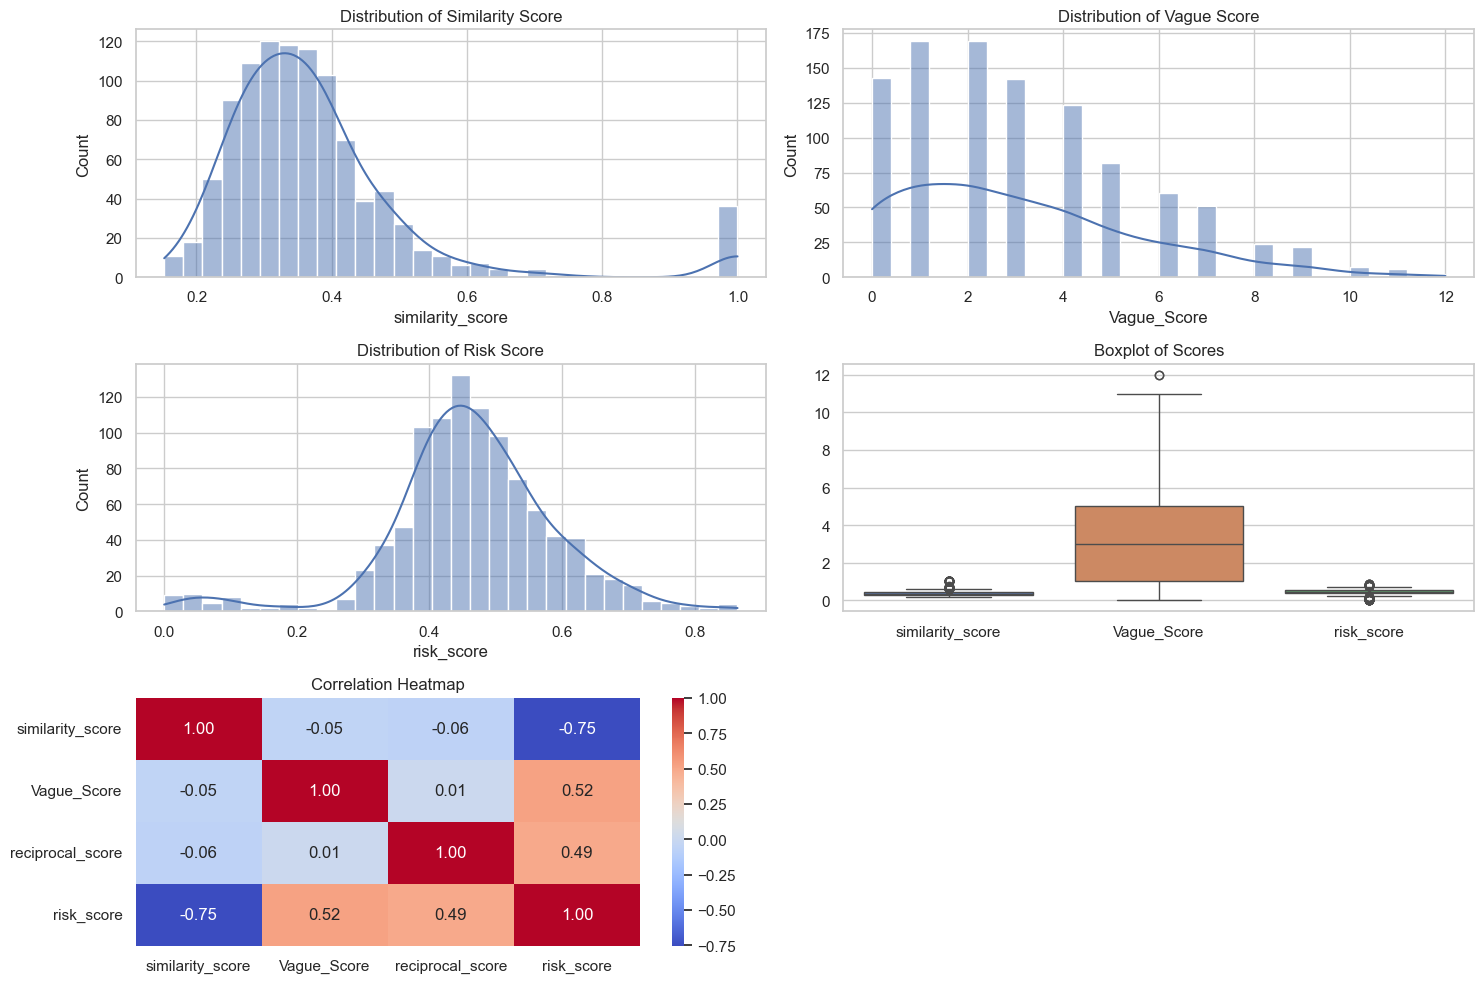

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'risk_score.csv'  # Update this to your CSV file path
data = pd.read_csv(file_path)

# Set up the visualization style
sns.set(style="whitegrid")

# Plotting distributions for the scores
plt.figure(figsize=(15, 10))

# Similarity Score Distribution
plt.subplot(3, 2, 1)
sns.histplot(data['similarity_score'], bins=30, kde=True)
plt.title('Distribution of Similarity Score')

# Vague Score Distribution
plt.subplot(3, 2, 2)
sns.histplot(data['Vague_Score'], bins=30, kde=True)
plt.title('Distribution of Vague Score')

# Risk Score Distribution
plt.subplot(3, 2, 3)
sns.histplot(data['risk_score'], bins=30, kde=True)
plt.title('Distribution of Risk Score')

# Boxplot for Scores
plt.subplot(3, 2, 4)
sns.boxplot(data=data[['similarity_score', 'Vague_Score', 'risk_score']])
plt.title('Boxplot of Scores')

# Correlation Heatmap
plt.subplot(3, 2, 5)
correlation = data[['similarity_score', 'Vague_Score', 'reciprocal_score', 'risk_score']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

# Function to detect outliers using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Adding an outlier column for each relevant metric
data['similarity_outlier'] = data['similarity_score'].apply(lambda x: 1 if (x < (data['similarity_score'].quantile(0.25) - 1.5 * (data['similarity_score'].quantile(0.75) - data['similarity_score'].quantile(0.25))) or
                                                                       (x > (data['similarity_score'].quantile(0.75) + 1.5 * (data['similarity_score'].quantile(0.75) - data['similarity_score'].quantile(0.25))))) else 0)

data['vague_outlier'] = data['Vague_Score'].apply(lambda x: 1 if (x < (data['Vague_Score'].quantile(0.25) - 1.5 * (data['Vague_Score'].quantile(0.75) - data['Vague_Score'].quantile(0.25))) or
                                                                  (x > (data['Vague_Score'].quantile(0.75) + 1.5 * (data['Vague_Score'].quantile(0.75) - data['Vague_Score'].quantile(0.25))))) else 0)

data['risk_outlier'] = data['risk_score'].apply(lambda x: 1 if (x < (data['risk_score'].quantile(0.25) - 1.5 * (data['risk_score'].quantile(0.75) - data['risk_score'].quantile(0.25))) or
                                                                (x > (data['risk_score'].quantile(0.75) + 1.5 * (data['risk_score'].quantile(0.75) - data['risk_score'].quantile(0.25))))) else 0)

# Save the updated DataFrame to a new CSV file
output_file_path = 'risk_score_with_outliers.csv'  # Update this to your desired output path
data.to_csv(output_file_path, index=False)


# Data Analysis

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import ast
from collections import defaultdict
import community as community_louvain

In [ ]:
# -----------------------------
# 1. Load and Preprocess Data
# -----------------------------

# Load the dataset
train_df = pd.read_csv('train.csv')

# Display the first few rows to verify
print("Initial DataFrame:")
print(train_df.head())

# Function to parse recommender_ids from string to list
def parse_recommenders(recommender_str):
    """
    Parses the recommender_ids string into a list of integers.
    
    Parameters:
    - recommender_str (str): String representation of a list (e.g., "[412, 869, 233, 289]").
    
    Returns:
    - List[int]: List of recommender IDs.
    """
    try:
        # Safely evaluate the string to a Python list
        recommenders = ast.literal_eval(recommender_str)
        # Ensure the result is a list
        if isinstance(recommenders, list):
            # Filter out any non-integer values
            return [int(r) for r in recommenders if isinstance(r, int)]
        else:
            return []
    except (ValueError, SyntaxError):
        # In case of malformed data, return an empty list
        return []

# Apply the parsing function to create a new column
train_df['recommender_list'] = train_df['recommender_ids'].apply(parse_recommenders)

# Verify the transformation
print("\nDataFrame after parsing recommender_ids:")
print(train_df[['id', 'recommender_ids', 'recommender_list']].head())

# ----------------------------------
# 2. Build the Recommendation Graph
# ----------------------------------

def build_recommendation_graph(df, total_nodes=1000):
    """
    Builds a directed graph from the recommendation data.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'id' and 'recommender_list'.
    - total_nodes (int): Total number of nodes in the graph.
    
    Returns:
    - G (nx.DiGraph): Directed graph representing the recommendation network.
    """
    G = nx.DiGraph()
    
    # Add all nodes (0 to total_nodes-1)
    G.add_nodes_from(range(total_nodes), type='candidate')
    
    # Add edges based on recommendations
    for _, row in df.iterrows():
        candidate = row['id']
        recommenders = row['recommender_list']
        for recommender in recommenders:
            if 0 <= recommender < total_nodes and recommender != candidate:
                G.add_edge(recommender, candidate)
            else:
                print(f"Invalid recommender ID {recommender} for candidate {candidate}. Skipping.")
    
    return G

# Build the graph
G = build_recommendation_graph(train_df, total_nodes=1000)

# Summary of the graph
print("\nGraph Summary:")
# print(nx.info(G))

# -----------------------------------
# 3. Compute Centrality Scores
# -----------------------------------

def compute_centrality_scores(G):
    """
    Computes centrality scores for each node in the graph.
    
    Parameters:
    - G (nx.DiGraph): Directed graph.
    
    Returns:
    - centrality_df (pd.DataFrame): DataFrame containing centrality scores.
    """
    # Degree Centrality (in-degree and out-degree)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)
    
    # Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Closeness Centrality
    closeness_centrality = nx.closeness_centrality(G)
    
    # PageRank
    pagerank = nx.pagerank(G, alpha=0.85)
    
    # Create a DataFrame
    centrality_df = pd.DataFrame({
        'id': list(G.nodes()),
        'in_degree_centrality': [in_degree_centrality[node] for node in G.nodes()],
        'out_degree_centrality': [out_degree_centrality[node] for node in G.nodes()],
        'betweenness_centrality': [betweenness_centrality[node] for node in G.nodes()],
        'closeness_centrality': [closeness_centrality[node] for node in G.nodes()],
        'pagerank': [pagerank[node] for node in G.nodes()]
    })
    
    return centrality_df

# Compute centrality scores
centrality_df = compute_centrality_scores(G)

# Merge centrality scores with the original DataFrame
train_df = train_df.merge(centrality_df, on='id')

print("\nDataFrame with Centrality Scores:")
print(train_df.head())

# -----------------------------------
# 4. Detect Communities
# -----------------------------------

def detect_communities(G):
    """
    Detects communities in the graph using the Louvain Method.
    
    Parameters:
    - G (nx.DiGraph): Directed graph.
    
    Returns:
    - partition (dict): Dictionary mapping node to its community.
    """
    # Convert to undirected graph for community detection
    undirected_G = G.to_undirected()
    
    # Compute the best partition
    partition = community_louvain.best_partition(undirected_G)
    
    return partition

# Detect communities
partition = detect_communities(G)

# Assign community information to the DataFrame
train_df['community'] = train_df['id'].map(partition)

# Display community assignments
print("\nCommunity Assignments:")
print(train_df[['id', 'community']].head())

# -----------------------------------
# 5. Visualize the Graph
# -----------------------------------

def visualize_graph(G, partition, centrality_df, plot_type='full'):
    """
    Visualizes the graph with nodes colored by community and sized by centrality.
    
    Parameters:
    - G (nx.DiGraph): Directed graph.
    - partition (dict): Dictionary mapping node to its community.
    - centrality_df (pd.DataFrame): DataFrame containing centrality scores.
    - plot_type (str): 'full' to plot the entire graph, 'largest' to plot the largest community.
    """
    # Define a color palette
    num_communities = len(set(partition.values()))
    palette = sns.color_palette("hsv", num_communities)
    color_map = {comm: palette[i] for i, comm in enumerate(sorted(set(partition.values())))}
    
    if plot_type == 'full':
        nodes = G.nodes()
        # Assign colors based on community
        node_colors = [color_map[partition[node]] for node in nodes]
        # Assign node sizes based on betweenness centrality
        node_sizes = [centrality_df.loc[centrality_df['id'] == node, 'betweenness_centrality'].values[0]*1000 for node in nodes]
        
        # Generate layout
        print("Generating layout for the full graph...")
        pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
        
        plt.figure(figsize=(20, 15))
        nx.draw_networkx_nodes(G, pos,
                               node_color=node_colors,
                               node_size=node_sizes,
                               alpha=0.7,
                               linewidths=0.5,
                               edgecolors='grey')
        
        nx.draw_networkx_edges(G, pos,
                               alpha=0.1,
                               width=0.5)
        
        plt.title('Employee Recommendation Network with Communities')
        plt.axis('off')
        
        # Create a legend for communities
        for comm, color in color_map.items():
            plt.scatter([], [], c=[color], label=f'Community {comm}')
        
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper right', title='Communities')
        plt.show()
    
    elif plot_type == 'largest':
        # Identify the largest community
        community_counts = pd.Series(partition).value_counts()
        largest_comm = community_counts.idxmax()
        print(f"\nLargest Community: {largest_comm} with {community_counts.max()} candidates")
        
        # Extract nodes in the largest community
        nodes_in_largest_comm = [node for node, comm in partition.items() if comm == largest_comm]
        
        # Create a subgraph
        subgraph = G.subgraph(nodes_in_largest_comm)
        
        # Assign colors and sizes
        sub_node_colors = [color_map[partition[node]] for node in subgraph.nodes()]
        sub_node_sizes = [centrality_df.loc[centrality_df['id'] == node, 'betweenness_centrality'].values[0]*1000 for node in subgraph.nodes()]
        
        # Generate layout
        print("Generating layout for the largest community...")
        pos_sub = nx.spring_layout(subgraph, k=0.15, iterations=50, seed=42)
        
        plt.figure(figsize=(15, 10))
        nx.draw_networkx_nodes(subgraph, pos_sub,
                               node_color=sub_node_colors,
                               node_size=sub_node_sizes,
                               alpha=0.8,
                               linewidths=0.5,
                               edgecolors='grey')
        
        nx.draw_networkx_edges(subgraph, pos_sub,
                               alpha=0.2,
                               width=0.5)
        
        plt.title(f'Largest Community (Community {largest_comm}) Recommendation Network')
        plt.axis('off')
        plt.show()

# Visualize the full graph (can be cluttered for 1000 nodes)
# Uncomment the following line to plot the full graph
# visualize_graph(G, partition, centrality_df, plot_type='full')

# Visualize the largest community
visualize_graph(G, partition, centrality_df, plot_type='largest')

# -----------------------------------
# 6. Save the Results
# -----------------------------------

def save_updated_dataframe(df, filename='train_updated.csv'):
    """
    Saves the updated DataFrame with centrality and community scores to a CSV file.
    
    Parameters:
    - df (pd.DataFrame): Updated DataFrame.
    - filename (str): Name of the output CSV file.
    """
    df.to_csv(filename, index=False)
    print(f"\nUpdated DataFrame saved to '{filename}'")

# Save the updated DataFrame
save_updated_dataframe(train_df, filename='train_updated.csv')

# Optionally, save similarity scores if needed
def save_similarity_scores(similarity_df, filename='similarity_scores.csv'):
    """
    Saves the similarity scores DataFrame to a CSV file.
    
    Parameters:
    - similarity_df (pd.DataFrame): DataFrame containing similarity scores.
    - filename (str): Name of the output CSV file.
    """
    similarity_df.to_csv(filename, index=False)
    print(f"Similarity scores saved to '{filename}'")

# Uncomment the following line to save similarity scores
# save_similarity_scores(similarity_df, filename='similarity_scores.csv')

# -----------------------------------
# End of Script
# -----------------------------------

# HR Dashboard

Candidate Ranking System

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import ast
from collections import defaultdict
import community as community_louvain

In [ ]:
# -----------------------------
# 1. Load and Preprocess Data
# -----------------------------

# Load the dataset
train_df = pd.read_csv('train.csv')

# Display the first few rows to verify
print("Initial DataFrame:")
print(train_df.head())

# Function to parse recommender_ids from string to list
def parse_recommenders(recommender_str):
    """
    Parses the recommender_ids string into a list of integers.
    
    Parameters:
    - recommender_str (str): String representation of a list (e.g., "[412, 869, 233, 289]").
    
    Returns:
    - List[int]: List of recommender IDs.
    """
    try:
        # Safely evaluate the string to a Python list
        recommenders = ast.literal_eval(recommender_str)
        # Ensure the result is a list
        if isinstance(recommenders, list):
            # Filter out any non-integer values
            return [int(r) for r in recommenders if isinstance(r, int)]
        else:
            return []
    except (ValueError, SyntaxError):
        # In case of malformed data, return an empty list
        return []

# Apply the parsing function to create a new column
train_df['recommender_list'] = train_df['recommender_ids'].apply(parse_recommenders)

# Verify the transformation
print("\nDataFrame after parsing recommender_ids:")
print(train_df[['id', 'recommender_ids', 'recommender_list']].head())

# ----------------------------------
# 2. Build the Recommendation Graph
# ----------------------------------

def build_recommendation_graph(df, total_nodes=1000):
    """
    Builds a directed graph from the recommendation data.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'id' and 'recommender_list'.
    - total_nodes (int): Total number of nodes in the graph.
    
    Returns:
    - G (nx.DiGraph): Directed graph representing the recommendation network.
    """
    G = nx.DiGraph()
    
    # Add all nodes (0 to total_nodes-1)
    G.add_nodes_from(range(total_nodes), type='candidate')
    
    # Add edges based on recommendations
    for _, row in df.iterrows():
        candidate = row['id']
        recommenders = row['recommender_list']
        for recommender in recommenders:
            if 0 <= recommender < total_nodes and recommender != candidate:
                G.add_edge(recommender, candidate)
            else:
                print(f"Invalid recommender ID {recommender} for candidate {candidate}. Skipping.")
    
    return G

# Build the graph
G = build_recommendation_graph(train_df, total_nodes=1000)

# Summary of the graph
print("\nGraph Summary:")
# print(nx.info(G))

# -----------------------------------
# 3. Compute Centrality Scores
# -----------------------------------

def compute_centrality_scores(G):
    """
    Computes centrality scores for each node in the graph.
    
    Parameters:
    - G (nx.DiGraph): Directed graph.
    
    Returns:
    - centrality_df (pd.DataFrame): DataFrame containing centrality scores.
    """
    # Degree Centrality (in-degree and out-degree)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)
    
    # Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Closeness Centrality
    closeness_centrality = nx.closeness_centrality(G)
    
    # PageRank
    pagerank = nx.pagerank(G, alpha=0.85)
    
    # Create a DataFrame
    centrality_df = pd.DataFrame({
        'id': list(G.nodes()),
        'in_degree_centrality': [in_degree_centrality[node] for node in G.nodes()],
        'out_degree_centrality': [out_degree_centrality[node] for node in G.nodes()],
        'betweenness_centrality': [betweenness_centrality[node] for node in G.nodes()],
        'closeness_centrality': [closeness_centrality[node] for node in G.nodes()],
        'pagerank': [pagerank[node] for node in G.nodes()]
    })
    
    return centrality_df

# Compute centrality scores
centrality_df = compute_centrality_scores(G)

# Merge centrality scores with the original DataFrame
train_df = train_df.merge(centrality_df, on='id')

print("\nDataFrame with Centrality Scores:")
print(train_df.head())

# -----------------------------------
# 4. Detect Communities
# -----------------------------------

def detect_communities(G):
    """
    Detects communities in the graph using the Louvain Method.
    
    Parameters:
    - G (nx.DiGraph): Directed graph.
    
    Returns:
    - partition (dict): Dictionary mapping node to its community.
    """
    # Convert to undirected graph for community detection
    undirected_G = G.to_undirected()
    
    # Compute the best partition
    partition = community_louvain.best_partition(undirected_G)
    
    return partition

# Detect communities
partition = detect_communities(G)

# Assign community information to the DataFrame
train_df['community'] = train_df['id'].map(partition)

# Display community assignments
print("\nCommunity Assignments:")
print(train_df[['id', 'community']].head())

# -----------------------------------
# 5. Visualize the Graph
# -----------------------------------

def visualize_graph(G, partition, centrality_df, plot_type='full'):
    """
    Visualizes the graph with nodes colored by community and sized by centrality.
    
    Parameters:
    - G (nx.DiGraph): Directed graph.
    - partition (dict): Dictionary mapping node to its community.
    - centrality_df (pd.DataFrame): DataFrame containing centrality scores.
    - plot_type (str): 'full' to plot the entire graph, 'largest' to plot the largest community.
    """
    # Define a color palette
    num_communities = len(set(partition.values()))
    palette = sns.color_palette("hsv", num_communities)
    color_map = {comm: palette[i] for i, comm in enumerate(sorted(set(partition.values())))}
    
    if plot_type == 'full':
        nodes = G.nodes()
        # Assign colors based on community
        node_colors = [color_map[partition[node]] for node in nodes]
        # Assign node sizes based on betweenness centrality
        node_sizes = [centrality_df.loc[centrality_df['id'] == node, 'betweenness_centrality'].values[0]*1000 for node in nodes]
        
        # Generate layout
        print("Generating layout for the full graph...")
        pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
        
        plt.figure(figsize=(20, 15))
        nx.draw_networkx_nodes(G, pos,
                               node_color=node_colors,
                               node_size=node_sizes,
                               alpha=0.7,
                               linewidths=0.5,
                               edgecolors='grey')
        
        nx.draw_networkx_edges(G, pos,
                               alpha=0.1,
                               width=0.5)
        
        plt.title('Employee Recommendation Network with Communities')
        plt.axis('off')
        
        # Create a legend for communities
        for comm, color in color_map.items():
            plt.scatter([], [], c=[color], label=f'Community {comm}')
        
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper right', title='Communities')
        plt.show()
    
    elif plot_type == 'largest':
        # Identify the largest community
        community_counts = pd.Series(partition).value_counts()
        largest_comm = community_counts.idxmax()
        print(f"\nLargest Community: {largest_comm} with {community_counts.max()} candidates")
        
        # Extract nodes in the largest community
        nodes_in_largest_comm = [node for node, comm in partition.items() if comm == largest_comm]
        
        # Create a subgraph
        subgraph = G.subgraph(nodes_in_largest_comm)
        
        # Assign colors and sizes
        sub_node_colors = [color_map[partition[node]] for node in subgraph.nodes()]
        sub_node_sizes = [centrality_df.loc[centrality_df['id'] == node, 'betweenness_centrality'].values[0]*1000 for node in subgraph.nodes()]
        
        # Generate layout
        print("Generating layout for the largest community...")
        pos_sub = nx.spring_layout(subgraph, k=0.15, iterations=50, seed=42)
        
        plt.figure(figsize=(15, 10))
        nx.draw_networkx_nodes(subgraph, pos_sub,
                               node_color=sub_node_colors,
                               node_size=sub_node_sizes,
                               alpha=0.8,
                               linewidths=0.5,
                               edgecolors='grey')
        
        nx.draw_networkx_edges(subgraph, pos_sub,
                               alpha=0.2,
                               width=0.5)
        
        plt.title(f'Largest Community (Community {largest_comm}) Recommendation Network')
        plt.axis('off')
        plt.show()

# Visualize the full graph (can be cluttered for 1000 nodes)
# Uncomment the following line to plot the full graph
# visualize_graph(G, partition, centrality_df, plot_type='full')

# Visualize the largest community
visualize_graph(G, partition, centrality_df, plot_type='largest')

# -----------------------------------
# 6. Save the Results
# -----------------------------------

def save_updated_dataframe(df, filename='train_updated.csv'):
    """
    Saves the updated DataFrame with centrality and community scores to a CSV file.
    
    Parameters:
    - df (pd.DataFrame): Updated DataFrame.
    - filename (str): Name of the output CSV file.
    """
    df.to_csv(filename, index=False)
    print(f"\nUpdated DataFrame saved to '{filename}'")

# Save the updated DataFrame
save_updated_dataframe(train_df, filename='train_updated.csv')

# Optionally, save similarity scores if needed
def save_similarity_scores(similarity_df, filename='similarity_scores.csv'):
    """
    Saves the similarity scores DataFrame to a CSV file.
    
    Parameters:
    - similarity_df (pd.DataFrame): DataFrame containing similarity scores.
    - filename (str): Name of the output CSV file.
    """
    similarity_df.to_csv(filename, index=False)
    print(f"Similarity scores saved to '{filename}'")

# Uncomment the following line to save similarity scores
# save_similarity_scores(similarity_df, filename='similarity_scores.csv')

# -----------------------------------
# End of Script
# -----------------------------------